In [1]:
## Has a lot of already implemented adversarial attacks like FGSM, PGD, BIM, CW, DeepFool etc.

!pip install torchattacks

     |████████████████████████████████| 105 kB 5.3 MB/s 


In [2]:
# !pip install git+https://github.com/BorealisAI/advertorch.git

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
import cv2
import pickle
import torchattacks
import random
from torchvision import models
import copy
import io
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 256
N_EPOCHS = 10

IMG_SIZE = 32
N_CLASSES = 10

In [8]:
transformations = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor(),])

train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transformations,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transformations)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

HTTPError: ignored

In [ ]:
bb_transformations = transforms.Compose([transforms.Resize(size=(32, 32)),
                                 transforms.ToTensor(),])

bb_train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=bb_transformations,
                               download=True)

bb_valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=bb_transformations)

bb_train_loader = DataLoader(dataset=bb_train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

bb_valid_loader = DataLoader(dataset=bb_valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

n_total_step = len(bb_train_loader)
print(n_total_step)

235


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Adversarial Machine Learning/Datasets/MNIST/mnist_train.csv', header=None)
data.columns = data.columns.astype(str)

In [ ]:
print(data.head())

   0  1  2  3  4  5  6  7  8  ...  776  777  778  779  780  781  782  783  784
0  5  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0    0
1  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0    0
2  4  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0    0
3  1  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0    0
4  9  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0    0

[5 rows x 785 columns]


In [ ]:
train, test = train_test_split(data, test_size=0.2)

In [ ]:
# y_train = train['0']
# x_train = train.drop(['0', 'index'], axis=1)
# print(x_train.head())
# print(y_train.head())

   1  2  3  4  5  6  7  8  9  ...  776  777  778  779  780  781  782  783  784
0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0    0
1  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0    0
2  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0    0
3  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0    0
4  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0    0

[5 rows x 784 columns]
0    5
1    0
2    4
3    1
4    9
Name: 0, dtype: int64


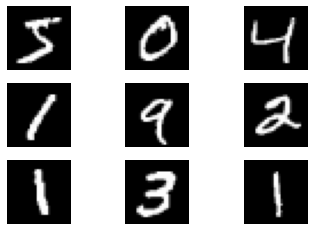

In [ ]:
# for index, row in x_train.iterrows():
#   plt.subplot(3, 3, index+1)
#   plt.imshow(row.to_numpy().reshape(28, 28), cmap=plt.get_cmap('gray'))
#   plt.axis('off')
#   # plt.imshow()
#   if index == 8:
#     break

In [ ]:
class MNISTDataset(Dataset):

    def __init__(self, df, transform=None):
        
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.df.iloc[idx, 1:]
        y_true = self.df.iloc[idx, 0]
        img = np.array([img])
        img = np.reshape(img, (28, 28))
        x = img.copy()
        x.resize((32, 32))
        x = torch.from_numpy(x).float().unsqueeze(0)

        # if self.transform:
        #     sample = self.transform(x)

        return x, y_true

In [ ]:
# transforms = transforms.Compose([transforms.ToTensor()])

train_dataset = MNISTDataset(train, transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)

valid_dataset = MNISTDataset(test, transforms)

valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)

### Dataset Analysis


In [ ]:
# Source used for graph plotting: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

pca = PCA(n_components=3)
pca_result = pca.fit_transform(x_train.values)

df = pd.DataFrame({'pca-one': pca_result[:,0], 'pca-two': pca_result[:,1], 'pca-three': pca_result[:,2], 'y': y_train})

# df['pca-one'] = pca_result[:,0]
# df['pca-two'] = pca_result[:,1] 
# df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09704664 0.07095924 0.06169089]


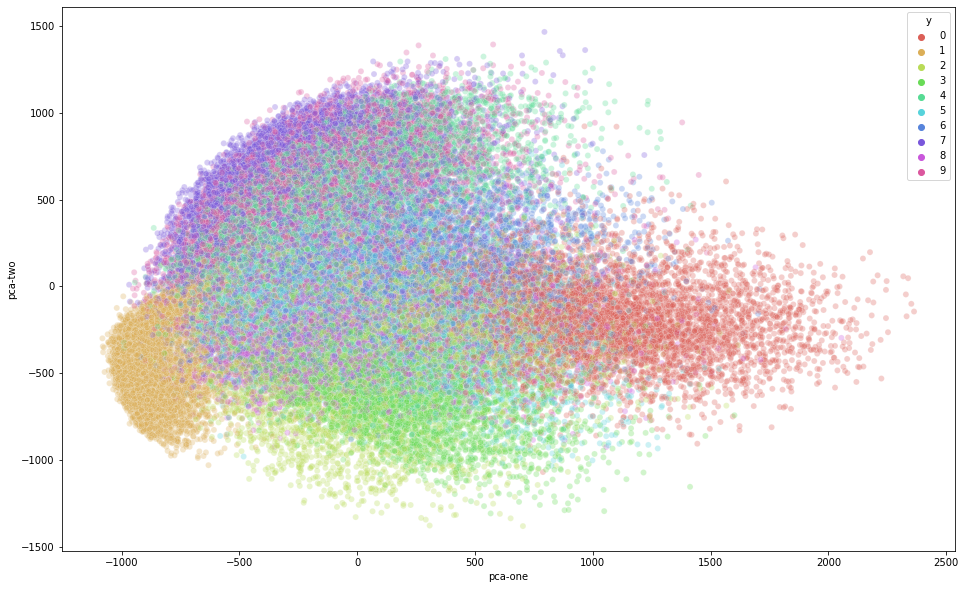

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[:],
    legend="full",
    alpha=0.3
)

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_train.loc[:10000].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.012s...
[t-SNE] Computed neighbors for 10001 samples in 8.804s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 545.025381
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.891060
[t-SNE] 

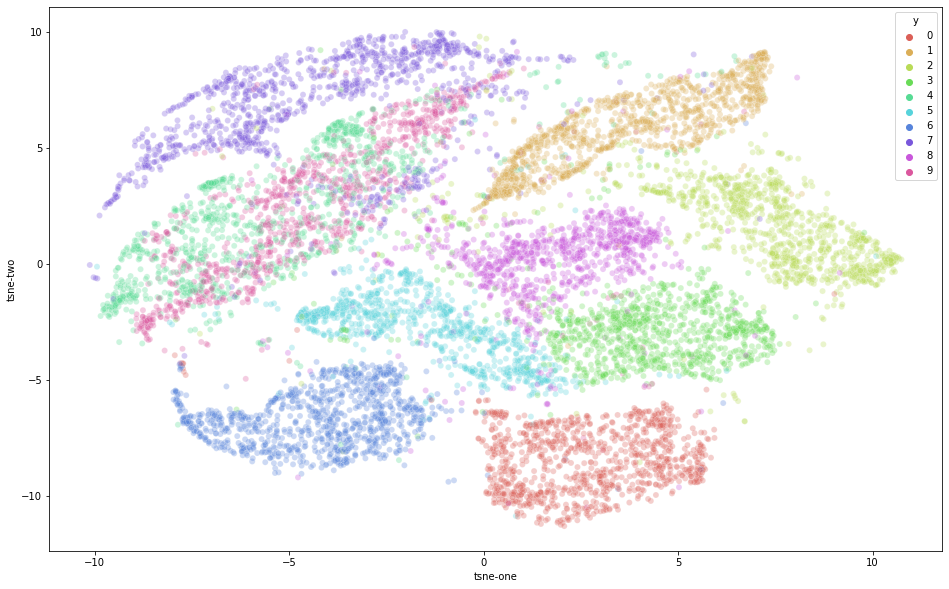

In [ ]:
df = pd.DataFrame({'tsne-one': tsne_results[:,0], 'tsne-two': tsne_results[:,1], 'y': y_train.loc[:10000]})

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

### Attacks

In [ ]:
## FGSM global parameters

FGSM_EPSILON = 0.2
loss_fn  = torch.nn.CrossEntropyLoss()

## Code loosely from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

def FGSM(model, x, y, fgsm_epsilon):

    x.requires_grad = True
    logits = model(x)
    prediction = F.softmax(logits, dim=1)
    loss = loss_fn(prediction, y)
    loss.backward()
    
    x_grad = x.grad.data
    sign = x_grad.sign()
    x_adv = x + fgsm_epsilon*sign
    x_adv = torch.clamp(x_adv, 0, 1)

    return x_adv

In [ ]:
## CHECK IF FINAL SAMPLE IS IN [0, 1]

## PGD global parameters

LOSS_FN  = torch.nn.CrossEntropyLoss()
NUM_STEPS = 10
STEP_SIZE = 0.03
EPS = 0.3     # 0.0, 6.1, 1./3
STEP_NORM = 'inf'   # 'inf'
EPS_NORM = 'inf'

## Code from https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3

def projected_gradient_descent(model, x, y, loss_fn, num_steps, step_size, step_norm, eps, eps_norm,
                               clamp=(0,1), y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    # x_adv = x.clone().detach().requires_grad_(True).to(x.device)
    x_adv = x.clone()
    targeted = y_target is not None
    num_channels = x.shape[1]

    for i in range(num_steps):
        # _x_adv = x_adv.clone().detach().requires_grad_(True)
        _x_adv = x_adv.clone()
        _x_adv.requires_grad = True

        logits = model(_x_adv)
        prediction = F.softmax(logits, dim=1)
        loss = loss_fn(prediction, y_target if targeted else y)
        loss.backward()

        # with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
        if step_norm == 'inf':
            gradients = _x_adv.grad.sign() * step_size
        else:
                # Note .view() assumes batched image data as 4D tensor
            gradients = _x_adv.grad * step_size / _x_adv.grad.view(_x_adv.shape[0], -1)\
                .norm(step_norm, dim=-1)\
                .view(-1, num_channels, 1, 1)

        if targeted:
                # Targeted: Gradient descent with on the loss of the (incorrect) target label
                # w.r.t. the image data
            x_adv -= gradients
        else:
                # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                # the model parameters
            x_adv += gradients

        # Project back into l_norm ball and correct range
        if eps_norm == 'inf':
            # Workaround as PyTorch doesn't have elementwise clip
            x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
        else:
            delta = x_adv - x

            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            mask = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1) <= eps

            scaling_factor = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1)
            scaling_factor[mask] = eps

            # .view() assumes batched images as a 4D Tensor
            delta *= eps / scaling_factor.view(-1, 1, 1, 1)

            x_adv = x + delta
            
        x_adv = x_adv.clamp(*clamp)

    # return x_adv.detach().cpu()
    return x_adv

In [ ]:
## l0_attack.py -- attack a network optimizing for l_0 distance
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##

MAX_ITERATIONS = 10   # number of iterations to perform gradient descent
ABORT_EARLY = True      # abort gradient descent upon first valid solution
LEARNING_RATE = 1e-2    # larger values converge faster to less accurate results
INITIAL_CONST = 1e-3    # the first value of c to start at
LARGEST_CONST = 20     # the largest value of c to go up to before giving up
REDUCE_CONST = False    # try to lower c each iteration; faster to set to false
TARGETED = False        # should we target one specific class? or just be wrong?
CONST_FACTOR = 2.0      # f>1, rate at which we increase constant, smaller better

class CarliniL0():
    def __init__(self, model, num_labels = 10, batch_size = 1,
                 targeted = TARGETED, learning_rate = LEARNING_RATE,
                 max_iterations = MAX_ITERATIONS, abort_early = ABORT_EARLY,
                 initial_const = INITIAL_CONST, largest_const = LARGEST_CONST,
                 reduce_const = REDUCE_CONST, const_factor = CONST_FACTOR,
                 independent_channels = False):
        """
        The L_0 optimized attack. 
        Returns adversarial examples for the supplied model.
        targeted: True if we should perform a targetted attack, False otherwise.
        learning_rate: The learning rate for the attack algorithm. Smaller values
          produce better results but are slower to converge.
        max_iterations: The maximum number of iterations. Larger values are more
          accurate; setting too small will require a large learning rate and will
          produce poor results.
        abort_early: If true, allows early aborts if gradient descent gets stuck.
        initial_const: The initial tradeoff-constant to use to tune the relative
          importance of distance and confidence. Should be set to a very small
          value (but positive).
        largest_const: The largest constant to use until we report failure. Should
          be set to a very large value.
        const_factor: The rate at which we should increase the constant, when the
          previous constant failed. Should be greater than one, smaller is better.
        independent_channels: set to false optimizes for number of pixels changed,
          set to true (not recommended) returns number of channels changed.
        """

        self.model = model
        self.num_labels = num_labels
        self.image_size = 32
        self.num_channels = 1
        self.batch_size = batch_size

        self.TARGETED = targeted
        self.LEARNING_RATE = learning_rate
        self.MAX_ITERATIONS = max_iterations
        self.ABORT_EARLY = abort_early
        self.INITIAL_CONST = initial_const    # c
        self.LARGEST_CONST = largest_const
        self.REDUCE_CONST = reduce_const
        self.const_factor = const_factor
        self.independent_channels = independent_channels

        self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = False

       
    def doit(self, oimgs, labs, starts, valid, CONST):
        # convert to tanh-space
        # print(torch.max(oimgs), torch.min(oimgs))
        # print(torch.max(starts), torch.min(starts))
        
        imgs = torch.atanh(oimgs)
        starts = torch.atanh(starts)

        shape = (self.batch_size, self.num_channels, self.image_size, self.image_size)
        
        # the variable to optimize over
        modifier = torch.nn.parameter.Parameter(torch.zeros(shape, dtype=torch.float32, device=device), requires_grad=True)

        # the variables we're going to hold, use for efficiency
        canchange = valid.to(device)
        simg = starts.to(device)
        original = oimgs.to(device)
        timg = imgs.to(device)
        tlab = labs.to(device)
        const = []

        tlab = torch.nn.functional.one_hot(tlab, num_classes= 10)
        
        optimizer = torch.optim.Adam([modifier], lr=self.LEARNING_RATE)

        while CONST < self.LARGEST_CONST:
            # try solving for each value of the constant
            # print('try const', CONST)
            for step in range(self.MAX_ITERATIONS):

                # remember the old value
                oldmodifier = modifier
                
                newimg = (torch.tanh(modifier + simg)/2)*canchange+(1-canchange)*original
        
                # print(torch.any(modifier.isnan()))
                
                output = self.model(newimg)
                
                real = torch.sum((tlab)*output,-1)
                other = torch.maximum(torch.max((1-tlab)*output - (tlab*10000)), torch.tensor(1.0, device=device))

                if self.TARGETED:
                    # if targetted, optimize for making the other class most likely
                    loss1 = torch.maximum(torch.tensor(0.0, device=device), other-real+.01)
                else:
                    # if untargeted, optimize for making this class least likely.
                    loss1 = torch.maximum(torch.tensor(0.0, device=device), real-other+.01)

                # sum up the losses
                loss2 = torch.sum(torch.square(newimg-torch.tanh(timg)/2))
                loss = CONST*loss1+loss2
                
                works = loss1
                scores = output
                
                # if step%(self.MAX_ITERATIONS//1) == 0:
                #     print(step,loss1,loss2)

                # return 0
                
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()

                if torch.all(scores>=-.0001) and torch.all(scores <= 1.0001):
                    if torch.allclose(torch.sum(scores,axis=1), 1.0, atol=1e-3):
                        if not self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK:
                            raise Exception("The output of model.predict should return the pre-softmax layer. It looks like you are returning the probability vector (post-softmax). If you are sure you want to do that, set attack.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = True")
                    
                if works < .0001 and self.ABORT_EARLY:
                    # it worked previously, restore the old value and finish
                    
                    modifier = oldmodifier
                    grads = torch.autograd.grad(loss, modifier, torch.ones_like(loss))[0]
                    nimg = (torch.tanh(modifier + simg)/2)*canchange+(1-canchange)*original

                    l2s=torch.square(nimg-torch.tanh(imgs)/2).sum(axis=(1,2,3))
                    return grads, scores, nimg, CONST

            # we didn't succeed, increase constant and try again
            CONST *= self.const_factor
        # return doit
        
    def attack(self, imgs, targets):
        """
        Perform the L_0 attack on the given images for the given targets.
        If self.targeted is true, then the targets represents the target labels.
        If self.targeted is false, then targets are the original class labels.
        """
        r = torch.tensor([], device=device)
        for i,(img,target) in enumerate(zip(imgs, targets)):
            print("Attack iteration",i)
            r = torch.cat((r, self.attack_single(img, target)), dim=0)
        return r

    def attack_single(self, img, target):
        """
        Run the attack on a single image and label
        """

        # the pixels we can change
        valid = torch.ones((self.batch_size,self.num_channels,self.image_size,self.image_size))

        # the previous image
        prev = img.clone().reshape((self.batch_size,self.num_channels,self.image_size,self.image_size))

        # initially set the solution to None, if we can't find an adversarial
        # example then we will return None as the solution.
        last_solution = img.unsqueeze(0)
        const = self.INITIAL_CONST

        equal_count = None
    
        while True:
            # try to solve given this valid map
            res = self.doit(img.clone(), target, prev.clone(), 
                       valid, const)
            if res == None:
                # the attack failed, we return this as our final answer
                print("Final answer",equal_count)
                return last_solution
    
            # the attack succeeded, now we pick new pixels to set to 0
            restarted = False
            gradientnorm, scores, nimg, const = res
            if self.REDUCE_CONST: const /= 2
            
            equal_count = self.num_channels*self.image_size**2-torch.sum(torch.all(torch.abs(img-nimg[0])<.0001, dim=0, keepdim=True))
            # print("Forced equal:",torch.sum(1-valid),
            #       "Equal count:",equal_count)
            if torch.sum(valid) == 0:
                # if no pixels changed, return 
                return img.unsqueeze(0)
    
            if self.independent_channels:
                # we are allowed to change each channel independently
                valid = valid.flatten()
                totalchange = torch.abs(nimg[0]-img)*torch.abs(gradientnorm[0])
            else:
                # we care only about which pixels change, not channels independently
                # compute total change as sum of change for each channel
                valid = valid.flatten()
                totalchange = torch.abs(torch.sum(nimg[0]-img,axis=0))*torch.sum(torch.abs(gradientnorm[0]),axis=0)
            totalchange = totalchange.flatten()

            # set some of the pixels to 0 depending on their total change
            did = 0
            for e in torch.argsort(totalchange):
                if torch.all(valid[e]):
                    did += 1
                    valid[e] = 0

                    if totalchange[e] > .01:
                        # if this pixel changed a lot, skip
                        break
                    if did >= .3*equal_count**.5:
                        # if we changed too many pixels, skip
                        break

            valid = torch.reshape(valid,(self.batch_size,self.num_channels, self.image_size,self.image_size))
            # print("Now forced equal:",torch.sum(1-valid))
    
            last_solution = prev = nimg

### Model

In [ ]:
## Model from https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        # print(torch.any(x.isnan()))
        x = self.feature_extractor(x)
        # print(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        # probs = F.softmax(logits, dim=1)
        # return logits, probs
        return logits

In [ ]:
class ClassificationDefense(nn.Module):

    def __init__(self, n_adv_classes, n_classes):
        super(ClassificationDefense, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.adv_classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_adv_classes),
        )
        
        self.class_classifier = nn.Sequential(
            nn.Linear(in_features=120 + n_adv_classes, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        adv_logits = self.adv_classifier(x)
        comb_features = torch.cat((x, adv_logits), dim=1)
        logits = self.class_classifier(comb_features)
        # probs = F.softmax(logits, dim=1)
        # return logits, probs
        return adv_logits, logits

### Black Box Model Training

In [ ]:
## Model from https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320

class BB_LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(BB_LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=240, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=240, out_features=168),
            nn.Tanh(),
            nn.Linear(in_features=168, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        # probs = F.softmax(logits, dim=1)
        # return logits, probs
        return logits

In [ ]:
bb_model = BB_LeNet5(N_CLASSES)
# input_lastLayer = bb_model.classifier[1].in_features
# # print(input_lastLayer)
# bb_model.classifier[1] = nn.Linear(input_lastLayer, N_CLASSES)
bb_model = bb_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(bb_model.parameters(), lr = LEARNING_RATE, momentum=0.9,weight_decay=5e-4)

In [ ]:
for epoch in range(N_EPOCHS):
    for i, (imgs , labels) in enumerate(bb_train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        labels_hat = bb_model(imgs)
        n_corrects = (labels_hat.argmax(axis=1)==labels).sum().item()
        loss_value = criterion(labels_hat, labels)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i+1) % 250 == 0:
            print(f'epoch {epoch+1}/{N_EPOCHS}, step: {i+1}/{n_total_step}: loss = {loss_value:.5f}, acc = {100*(n_corrects/labels.size(0)):.2f}%')
    print()

epoch 1/10, step: 250/1875: loss = 2.15054, acc = 50.00%
epoch 1/10, step: 500/1875: loss = 1.31375, acc = 71.88%
epoch 1/10, step: 750/1875: loss = 0.60097, acc = 87.50%
epoch 1/10, step: 1000/1875: loss = 0.55655, acc = 84.38%
epoch 1/10, step: 1250/1875: loss = 0.43997, acc = 87.50%
epoch 1/10, step: 1500/1875: loss = 0.56791, acc = 81.25%
epoch 1/10, step: 1750/1875: loss = 0.49570, acc = 84.38%

epoch 2/10, step: 250/1875: loss = 0.33965, acc = 84.38%
epoch 2/10, step: 500/1875: loss = 0.44912, acc = 87.50%
epoch 2/10, step: 750/1875: loss = 0.23906, acc = 90.62%
epoch 2/10, step: 1000/1875: loss = 0.17113, acc = 93.75%
epoch 2/10, step: 1250/1875: loss = 0.34515, acc = 84.38%
epoch 2/10, step: 1500/1875: loss = 0.36046, acc = 87.50%
epoch 2/10, step: 1750/1875: loss = 0.44062, acc = 93.75%

epoch 3/10, step: 250/1875: loss = 0.12499, acc = 100.00%
epoch 3/10, step: 500/1875: loss = 0.26069, acc = 93.75%
epoch 3/10, step: 750/1875: loss = 0.35779, acc = 84.38%
epoch 3/10, step: 10

In [ ]:
with torch.no_grad():
    number_corrects = 0
    number_samples = 0
    for i, (test_images_set , test_labels_set) in enumerate(bb_valid_loader):
        test_images_set = test_images_set.to(device)
        test_labels_set = test_labels_set.to(device)
    
        y_predicted = bb_model(test_images_set)
        labels_predicted = y_predicted.argmax(axis = 1)
        number_corrects += (labels_predicted==test_labels_set).sum().item()
        number_samples += test_labels_set.size(0)
    print(f'Overall accuracy {(number_corrects / number_samples)*100}%')

Overall accuracy 97.99%


In [ ]:
pickle.dump(bb_model, open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/BB_LeNet5_MNIST_normal_trained_model.pkl', 'wb'))

In [ ]:
bb_model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/BB_LeNet5_MNIST_normal_trained_model.pkl', 'rb'))

### Normal Training Function

In [ ]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    correct_pred = 0 
    n = 0
    
    model.train()
    running_loss = 0
    
    for X, y_true in tqdm(train_loader):

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

        y_prob = F.softmax(y_hat, dim=1)
        _, predicted_labels = torch.max(y_prob, 1)

        n += y_true.size(0)
        correct_pred += (predicted_labels == y_true).sum()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    acc = correct_pred.float() / n
    return model, optimizer, epoch_loss, acc

### Adversarial Training Function

In [ ]:
def adv_train(train_loader, model, criterion, optimizer, device, attack, adv_training_prob):
    '''
    Function for the training step of the training loop
    '''

    correct_pred = 0 
    n = 0
    
    model.train()
    running_loss = 0
    
    for X, y_true in tqdm(train_loader):

        rand = random.random()
        
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
        
        if adv_training_prob > rand:
            if attack == 'pgd':
                x_adv = projected_gradient_descent(model, X, y_true, LOSS_FN, NUM_STEPS, STEP_SIZE, STEP_NORM, EPS, EPS_NORM)
                # atk = torchattacks.PGD(model, eps=EPS, alpha=STEP_SIZE, steps=10)
                # x_adv = atk(x, y)
            elif attack == 'fgsm':
                # x_adv = FGSM(model, X, y_true, FGSM_EPSILON)
                atk = torchattacks.FGSM(model, eps=FGSM_EPSILON)
                x_adv = atk(X, y_true)
            elif attack == 'cw':
                atk = torchattacks.CW(model, c=C, kappa=KAPPA, steps=STEPS, lr=LR)
                x_adv = atk(X, y_true)
            elif attack == 'deepfool':
                atk = torchattacks.DeepFool(model, steps=DF_STEPS, overshoot=OVERSHOOT)
                x_adv = atk(X, y_true)
        
            # Forward pass
            y_hat = model(x_adv.to(device))
        else:
            y_hat = model(X)
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

        y_prob = F.softmax(y_hat, dim=1)
        _, predicted_labels = torch.max(y_prob, 1)

        n += y_true.size(0)
        correct_pred += (predicted_labels == y_true).sum()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    acc = correct_pred.float() / n
    return model, optimizer, epoch_loss, acc

### Normal Valdiation Function

In [ ]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    correct_pred = 0 
    n = 0
    
    model.eval()
    running_loss = 0
    
    for X, y_true in tqdm(valid_loader):
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        y_prob = F.softmax(y_hat, dim=1)
        _, predicted_labels = torch.max(y_prob, 1)

        n += y_true.size(0)
        correct_pred += (predicted_labels == y_true).sum()

    epoch_loss = running_loss / len(valid_loader.dataset)
    acc = correct_pred.float() / n
        
    return model, epoch_loss, acc

### Adversarial Validation Function

In [ ]:
def adv_validate(valid_loader, model, criterion, device, attack, bb_model=None):
    '''
    Function for the validation step of the training loop
    '''
   
    correct_pred = 0 
    n = 0
    
    model.eval()
    running_loss = 0
    
    # White box attack
    if not bb_model:
        bb_model = model

    for X, y_true in tqdm(valid_loader):
    
        X = X.to(device)
        y_true = y_true.to(device)
        if attack == 'pgd':
            x_adv = projected_gradient_descent(bb_model, X, y_true, LOSS_FN, NUM_STEPS, STEP_SIZE, STEP_NORM, EPS, EPS_NORM)
            # atk = torchattacks.PGD(bb_model, eps=EPS, alpha=STEP_SIZE, steps=10)
            # x_adv = atk(x, y)
        elif attack == 'fgsm':
            x_adv = FGSM(bb_model, X, y_true, FGSM_EPSILON)
            # atk = torchattacks.FGSM(bb_model, eps=FGSM_EPSILON)
            # x_adv = atk(X, y_true)
        elif attack == 'cw':
            atk = torchattacks.CW(bb_model, c=C, kappa=KAPPA, steps=STEPS, lr=LR)
            x_adv = atk(X, y_true)
        elif attack == 'deepfool':
            atk = torchattacks.DeepFool(bb_model, steps=DF_STEPS, overshoot=OVERSHOOT)
            x_adv = atk(X, y_true)

        # Forward pass and record loss
        y_hat = model(x_adv.to(device))
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * x_adv.size(0)

        y_prob = F.softmax(y_hat, dim=1)
        _, predicted_labels = torch.max(y_prob, 1)

        n += y_true.size(0)
        correct_pred += (predicted_labels == y_true).sum()

    epoch_loss = running_loss / len(valid_loader.dataset)
    acc = correct_pred.float() / n
        
    return model, epoch_loss, acc

### Main functions

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, adv_training, adv_training_prob, adv_val, attack, logs, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    start_epoch = logs['epochs']
 
    # Train model
    for epoch in range(start_epoch, epochs):

        # training
        if adv_training:
            model, optimizer, train_loss, train_acc = adv_train(train_loader, model, criterion, optimizer, device, attack, adv_training_prob)
        else:
            model, optimizer, train_loss, train_acc = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        if adv_val:
            model, adv_valid_loss, adv_valid_acc = adv_validate(valid_loader, model, criterion, device, attack)
            # adv_valid_acc = get_adv_accuracy(model, valid_loader, device, attack)
        with torch.no_grad():
            model, valid_loss, valid_acc = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
                        
            if adv_val:
                logs['epochs'] = epoch + 1
                logs['Train loss'].append(train_loss)
                logs['Valid loss'].append(valid_loss)
                logs['Train acc'].append(train_acc)
                logs['Valid acc'].append(valid_acc)
                logs['ADV Valid acc'].append(adv_valid_acc)
                logs['ADV Valid loss'].append(adv_valid_loss)
                print(f'{datetime.now().time().replace(microsecond=0)} --- '
                      f'Epoch: {epoch}\t'
                      f'Train loss: {train_loss:.4f}\t'
                      f'Valid loss: {valid_loss:.4f}\t'
                      f'Train acc: {100 * train_acc:.2f}\t'
                      f'Valid acc: {100 * valid_acc:.2f}\t'
                      f'ADV Valid acc: {100 * adv_valid_acc:.2f}\t'
                      f'ADV Valid loss: {100 * adv_valid_loss:.2f}')
            else:
                logs['epochs'] = epoch + 1
                logs['Train loss'].append(train_loss)
                logs['Valid loss'].append(valid_loss)
                logs['Train acc'].append(train_acc)
                logs['Valid acc'].append(valid_acc)
                print(f'{datetime.now().time().replace(microsecond=0)} --- '
                      f'Epoch: {epoch}\t'
                      f'Train loss: {train_loss:.4f}\t'
                      f'Valid loss: {valid_loss:.4f}\t'
                      f'Train acc: {100 * train_acc:.2f}\t'
                      f'Valid acc: {100 * valid_acc:.2f}')
            
            # save_model(model, optimizer, epoch, logs)

    # plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [ ]:
def only_val_loop(model, criterion, valid_loader, epochs, device, adv_val, attack, print_every=1):
    
    valid_losses = []

    for epoch in range(0, epochs):

        # validation
        if adv_val:
            model, adv_valid_loss, adv_valid_acc = adv_validate(valid_loader, model, criterion, device, attack)
            # adv_valid_acc = get_adv_accuracy(model, valid_loader, device, attack)
        # with torch.no_grad():
        #     model, valid_loss, valid_acc = validate(valid_loader, model, criterion, device)
        valid_acc = 0
        #     valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
                
            # valid_acc = get_accuracy(model, valid_loader, device=device)
                        
            if adv_val:
                print(f'{datetime.now().time().replace(microsecond=0)} --- '
                      f'Epoch: {epoch}\t'
                      # f'Valid loss: {valid_loss:.4f}\t'
                      # f'Valid acc: {100 * valid_acc:.2f}\t'
                      f'ADV Valid acc: {100 * adv_valid_acc:.2f}\t'
                      f'ADV Valid loss: {100 * adv_valid_loss:.2f}')
            else:
                print(f'{datetime.now().time().replace(microsecond=0)} --- '
                      f'Epoch: {epoch}\t'
                      # f'Valid loss: {valid_loss:.4f}\t'
                      f'Valid acc: {100 * valid_acc:.2f}')

    # plot_losses(train_losses, valid_losses)
    
    return model, (adv_valid_acc, valid_acc)

In [ ]:
def black_box_val_loop(bb_model, model, criterion, valid_loader, epochs, device, attack, print_every=1):
    
    val_acc_list = []

    for epoch in range(0, epochs):

        # validation
        model, adv_valid_loss, adv_valid_acc = adv_validate(valid_loader, model, criterion, device, attack, bb_model=bb_model)
        val_acc_list.append(adv_valid_acc)
            # adv_valid_acc = get_adv_accuracy(model, valid_loader, device, attack)
        with torch.no_grad():
            model, valid_loss, valid_acc = validate(valid_loader, model, criterion, device)
            # valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
                
            # valid_acc = get_accuracy(model, valid_loader, device=device)
                        
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Valid acc: {100 * valid_acc:.2f}\t'
                  f'ADV Valid acc: {100 * adv_valid_acc:.2f}\t'
                  f'ADV Valid loss: {100 * adv_valid_loss:.2f}')

    # plot_losses(train_losses, valid_losses)
    
    return model, val_acc_list

In [ ]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

### Normal Training


In [ ]:
adv_training = False
adv_training_prob = 0.0
adv_val = True
attack = 'fgsm'

torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

logs = {}
logs['epochs'] = 0
logs['Train loss'] = []
logs['Valid loss'] = []
logs['Train acc'] = []
logs['Valid acc'] = []
logs['ADV Valid acc'] = []
logs['ADV Valid loss'] = []

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, device, adv_training, adv_training_prob, adv_val, attack, logs)

19:48:39 --- Epoch: 8	Train loss: 0.2290	Valid loss: 0.1020	Train acc: 93.30	Valid acc: 96.81	ADV Valid acc: 8.07	ADV Valid loss: 542.91
19:49:07 --- Epoch: 9	Train loss: 0.0768	Valid loss: 0.0703	Train acc: 97.62	Valid acc: 97.83	ADV Valid acc: 14.48	ADV Valid loss: 517.03


In [ ]:
adv_val = True
attack = 'pgd'

model, _ = only_val_loop(model, criterion, valid_loader, 1, device, adv_val, attack)

10:29:51 --- Epoch: 0	Valid loss: 0.0437	Valid acc: 98.65	ADV Valid acc: 11.67	ADV Valid loss: 825.91


### Adversarial Training

In [ ]:
adv_training = True
adv_training_prob = 0.5
adv_val = True
attack = 'pgd'

C = 10
LR = 0.5
KAPPA = 0.2
STEPS = 30

torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

logs = {}
logs['epochs'] = 0
logs['Train loss'] = []
logs['Valid loss'] = []
logs['Train acc'] = []
logs['Valid acc'] = []
logs['ADV Valid acc'] = []
logs['ADV Valid loss'] = []

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, 70, device, adv_training, adv_training_prob, adv_val, attack, logs)

100%|██████████| 40/40 [00:01<00:00, 36.90it/s]


13:30:03 --- Epoch: 60	Train loss: 0.3004	Valid loss: 0.1546	Train acc: 94.51	Valid acc: 96.93	ADV Valid acc: 91.80	ADV Valid loss: 42.62


100%|██████████| 40/40 [00:01<00:00, 38.69it/s]


13:30:17 --- Epoch: 61	Train loss: 0.2803	Valid loss: 0.1391	Train acc: 94.42	Valid acc: 97.11	ADV Valid acc: 92.59	ADV Valid loss: 39.55


100%|██████████| 40/40 [00:01<00:00, 26.21it/s]


13:30:32 --- Epoch: 62	Train loss: 0.2492	Valid loss: 0.1216	Train acc: 94.91	Valid acc: 97.16	ADV Valid acc: 92.48	ADV Valid loss: 37.47


100%|██████████| 40/40 [00:01<00:00, 38.67it/s]


13:30:46 --- Epoch: 63	Train loss: 0.2235	Valid loss: 0.1058	Train acc: 95.25	Valid acc: 97.49	ADV Valid acc: 92.01	ADV Valid loss: 36.60


100%|██████████| 40/40 [00:01<00:00, 38.58it/s]


13:31:00 --- Epoch: 64	Train loss: 0.2249	Valid loss: 0.1063	Train acc: 95.00	Valid acc: 97.61	ADV Valid acc: 92.64	ADV Valid loss: 33.56


100%|██████████| 40/40 [00:01<00:00, 37.49it/s]


13:31:15 --- Epoch: 65	Train loss: 0.2236	Valid loss: 0.1040	Train acc: 95.00	Valid acc: 97.59	ADV Valid acc: 92.91	ADV Valid loss: 33.18


100%|██████████| 40/40 [00:01<00:00, 38.06it/s]


13:31:28 --- Epoch: 66	Train loss: 0.1881	Valid loss: 0.1021	Train acc: 95.75	Valid acc: 97.58	ADV Valid acc: 92.86	ADV Valid loss: 33.80


100%|██████████| 40/40 [00:01<00:00, 38.17it/s]


13:31:43 --- Epoch: 67	Train loss: 0.1966	Valid loss: 0.1155	Train acc: 95.43	Valid acc: 97.26	ADV Valid acc: 92.88	ADV Valid loss: 33.60


100%|██████████| 40/40 [00:01<00:00, 38.39it/s]


13:31:57 --- Epoch: 68	Train loss: 0.1995	Valid loss: 0.0961	Train acc: 95.43	Valid acc: 97.76	ADV Valid acc: 92.93	ADV Valid loss: 32.39


100%|██████████| 40/40 [00:01<00:00, 38.15it/s]

13:32:13 --- Epoch: 69	Train loss: 0.2095	Valid loss: 0.0898	Train acc: 95.17	Valid acc: 97.68	ADV Valid acc: 93.05	ADV Valid loss: 30.60


In [ ]:
adv_val = True
attack = 'pgd'

model, _ = only_val_loop(model, criterion, valid_loader, 1, device, adv_val, attack)

100%|██████████| 40/40 [00:03<00:00, 12.38it/s]

12:56:25 --- Epoch: 0	ADV Valid acc: 80.94	ADV Valid loss: 65.32


### Randomized Initialization Test

In [ ]:
adv_val = True
seed_list = [10, 30, 42, 70, 100]
adv_training = True
adv_training_prob = 0.5
attack = 'fgsm'
acc_dict = {}
logs = {}

for seed in seed_list:

    torch.manual_seed(seed)

    logs['epochs'] = 0
    logs['Train loss'] = []
    logs['Valid loss'] = []
    logs['Train acc'] = []
    logs['Valid acc'] = []
    logs['ADV Valid acc'] = []
    logs['ADV Valid loss'] = []
    model = LeNet5(N_CLASSES).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, device, adv_training, adv_training_prob, adv_val, attack, logs)
    print('Black box attack result:')
    model, val_acc_list = black_box_val_loop(bb_model, model, criterion, valid_loader, 1, device, attack, print_every=1)
    acc_dict[seed] = val_acc_list

# plot_line_graphs(acc_dict)

20:41:33 --- Epoch: 9	Train loss: 0.1689	Valid loss: 0.0527	Train acc: 94.51	Valid acc: 98.33	ADV Valid acc: 89.34	ADV Valid loss: 32.83
Black box attack result:
20:41:39 --- Epoch: 0	Valid loss: 0.0527	Valid acc: 98.33	ADV Valid acc: 91.06	ADV Valid loss: 27.67
20:46:54 --- Epoch: 9	Train loss: 0.1701	Valid loss: 0.0473	Train acc: 94.46	Valid acc: 98.54	ADV Valid acc: 89.81	ADV Valid loss: 31.37
Black box attack result:
20:47:01 --- Epoch: 0	Valid loss: 0.0473	Valid acc: 98.54	ADV Valid acc: 91.84	ADV Valid loss: 26.12
20:52:15 --- Epoch: 9	Train loss: 0.1770	Valid loss: 0.0491	Train acc: 94.21	Valid acc: 98.52	ADV Valid acc: 89.07	ADV Valid loss: 33.86
Black box attack result:
20:52:21 --- Epoch: 0	Valid loss: 0.0491	Valid acc: 98.52	ADV Valid acc: 90.61	ADV Valid loss: 29.46
20:57:33 --- Epoch: 9	Train loss: 0.1799	Valid loss: 0.0533	Train acc: 94.12	Valid acc: 98.39	ADV Valid acc: 88.76	ADV Valid loss: 33.92
Black box attack result:
20:57:39 --- Epoch: 0	Valid loss: 0.0533	Valid ac

### FGSM parameter variation test

In [ ]:
if device == 'cpu':
    model1 = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/normal_trained_model.pkl', 'rb')).load()
    model2 = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/fgsm_trained_model.pkl', 'rb')).load()
    model3 = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/pgd_trained_model.pkl', 'rb')).load()
else:
    model1 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/normal_trained_model.pkl', 'rb'))
    model2 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/fgsm_trained_model.pkl', 'rb'))
    model3 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/pgd_trained_model.pkl', 'rb'))

model_list = [model1, model2, model3]

adv_val = True
fgsm_epsilon_list = list(np.linspace(0, 1, num=50, endpoint=True))
# fgsm_epsilon_list = range(0, 50, 1)
attack = 'fgsm'
acc_dict = {}
logs = {}

for fgsm_epsilon in fgsm_epsilon_list:
    
    model_acc_list = []
    for model in model_list:

        FGSM_EPSILON = fgsm_epsilon

        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()
        print('FGSM attack with epsilon', FGSM_EPSILON, 'result:')
        model, val_acc = only_val_loop(model, criterion, valid_loader, 1, device, adv_val, attack)
        model_acc_list.append(val_acc[0].cpu())

    acc_dict[fgsm_epsilon] = tuple(model_acc_list)

FGSM attack with epsilon 0.0 result:
07:32:15 --- Epoch: 0	ADV Valid acc: 98.65	ADV Valid loss: 4.37
FGSM attack with epsilon 0.0 result:
07:32:17 --- Epoch: 0	ADV Valid acc: 98.68	ADV Valid loss: 4.33
FGSM attack with epsilon 0.0 result:
07:32:20 --- Epoch: 0	ADV Valid acc: 98.42	ADV Valid loss: 4.96
FGSM attack with epsilon 0.02040816326530612 result:
07:32:22 --- Epoch: 0	ADV Valid acc: 94.58	ADV Valid loss: 20.61
FGSM attack with epsilon 0.02040816326530612 result:
07:32:24 --- Epoch: 0	ADV Valid acc: 98.36	ADV Valid loss: 5.46
FGSM attack with epsilon 0.02040816326530612 result:
07:32:27 --- Epoch: 0	ADV Valid acc: 97.99	ADV Valid loss: 5.95
FGSM attack with epsilon 0.04081632653061224 result:
07:32:29 --- Epoch: 0	ADV Valid acc: 85.52	ADV Valid loss: 56.20
FGSM attack with epsilon 0.04081632653061224 result:
07:32:32 --- Epoch: 0	ADV Valid acc: 97.89	ADV Valid loss: 6.80
FGSM attack with epsilon 0.04081632653061224 result:
07:32:34 --- Epoch: 0	ADV Valid acc: 97.67	ADV Valid loss

Text(0.5, 1.0, 'FGSM epsilon variation')

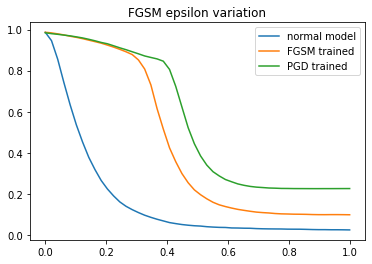

In [ ]:
plt.plot(list(acc_dict.keys()), list(acc_dict.values()))
plt.legend(['normal model', 'FGSM trained', 'PGD trained'])
plt.title('FGSM epsilon variation')

### PGD parameter variation test

In [ ]:
if device == 'cpu':
    model1 = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/normal_trained_model.pkl', 'rb')).load()
    model2 = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/fgsm_trained_model.pkl', 'rb')).load()
    model3 = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/pgd_trained_model.pkl', 'rb')).load()
else:
    model1 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/normal_trained_model.pkl', 'rb'))
    model2 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/fgsm_trained_model.pkl', 'rb'))
    model3 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/pgd_trained_model.pkl', 'rb'))

model_list = [model1, model2, model3]

adv_val = True
pgd_epsilon_list = list(np.linspace(0, 1, num=100, endpoint=True))
# pgd_steps_list = range(1, 101)
attack = 'pgd'
acc_dict = {}
logs = {}
NUM_STEPS = 10

for pgd_epsilon in pgd_epsilon_list:

    if pgd_epsilon == 0:
        continue
    
    model_acc_list = []
    for model in model_list:

        EPS = pgd_epsilon
        STEP_SIZE = EPS/NUM_STEPS
        LOSS_FN = nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()
        print('PGD attack with epsilon', EPS, 'result:')
        model, val_acc = only_val_loop(model, criterion, valid_loader, 1, device, adv_val, attack)
        model_acc_list.append(val_acc[0].cpu())

    acc_dict[pgd_epsilon] = tuple(model_acc_list)

PGD attack with epsilon 0.010101010101010102 result:


100%|██████████| 40/40 [00:02<00:00, 16.11it/s]


13:38:09 --- Epoch: 0	ADV Valid acc: 97.24	ADV Valid loss: 10.40
PGD attack with epsilon 0.010101010101010102 result:


100%|██████████| 40/40 [00:02<00:00, 16.96it/s]


13:38:12 --- Epoch: 0	ADV Valid acc: 98.53	ADV Valid loss: 4.86
PGD attack with epsilon 0.010101010101010102 result:


100%|██████████| 40/40 [00:02<00:00, 17.15it/s]


13:38:14 --- Epoch: 0	ADV Valid acc: 97.28	ADV Valid loss: 11.04
PGD attack with epsilon 0.020202020202020204 result:


100%|██████████| 40/40 [00:02<00:00, 16.99it/s]


13:38:17 --- Epoch: 0	ADV Valid acc: 93.66	ADV Valid loss: 23.89
PGD attack with epsilon 0.020202020202020204 result:


100%|██████████| 40/40 [00:02<00:00, 16.87it/s]


13:38:19 --- Epoch: 0	ADV Valid acc: 98.36	ADV Valid loss: 5.45
PGD attack with epsilon 0.020202020202020204 result:


100%|██████████| 40/40 [00:02<00:00, 17.24it/s]


13:38:21 --- Epoch: 0	ADV Valid acc: 96.92	ADV Valid loss: 12.43
PGD attack with epsilon 0.030303030303030304 result:


100%|██████████| 40/40 [00:02<00:00, 17.18it/s]


13:38:24 --- Epoch: 0	ADV Valid acc: 86.37	ADV Valid loss: 50.88
PGD attack with epsilon 0.030303030303030304 result:


100%|██████████| 40/40 [00:02<00:00, 17.10it/s]


13:38:26 --- Epoch: 0	ADV Valid acc: 98.15	ADV Valid loss: 6.11
PGD attack with epsilon 0.030303030303030304 result:


100%|██████████| 40/40 [00:02<00:00, 17.13it/s]


13:38:28 --- Epoch: 0	ADV Valid acc: 96.60	ADV Valid loss: 13.57
PGD attack with epsilon 0.04040404040404041 result:


100%|██████████| 40/40 [00:02<00:00, 17.01it/s]


13:38:31 --- Epoch: 0	ADV Valid acc: 75.71	ADV Valid loss: 96.82
PGD attack with epsilon 0.04040404040404041 result:


100%|██████████| 40/40 [00:02<00:00, 17.23it/s]


13:38:33 --- Epoch: 0	ADV Valid acc: 97.89	ADV Valid loss: 6.84
PGD attack with epsilon 0.04040404040404041 result:


100%|██████████| 40/40 [00:02<00:00, 16.93it/s]


13:38:35 --- Epoch: 0	ADV Valid acc: 96.45	ADV Valid loss: 14.44
PGD attack with epsilon 0.05050505050505051 result:


100%|██████████| 40/40 [00:02<00:00, 17.01it/s]


13:38:38 --- Epoch: 0	ADV Valid acc: 64.82	ADV Valid loss: 161.22
PGD attack with epsilon 0.05050505050505051 result:


100%|██████████| 40/40 [00:02<00:00, 16.95it/s]


13:38:40 --- Epoch: 0	ADV Valid acc: 97.62	ADV Valid loss: 7.65
PGD attack with epsilon 0.05050505050505051 result:


100%|██████████| 40/40 [00:02<00:00, 17.06it/s]


13:38:42 --- Epoch: 0	ADV Valid acc: 96.20	ADV Valid loss: 15.34
PGD attack with epsilon 0.06060606060606061 result:


100%|██████████| 40/40 [00:02<00:00, 17.23it/s]


13:38:45 --- Epoch: 0	ADV Valid acc: 55.91	ADV Valid loss: 238.23
PGD attack with epsilon 0.06060606060606061 result:


100%|██████████| 40/40 [00:02<00:00, 16.82it/s]


13:38:47 --- Epoch: 0	ADV Valid acc: 97.33	ADV Valid loss: 8.55
PGD attack with epsilon 0.06060606060606061 result:


100%|██████████| 40/40 [00:02<00:00, 17.06it/s]


13:38:49 --- Epoch: 0	ADV Valid acc: 96.07	ADV Valid loss: 16.01
PGD attack with epsilon 0.07070707070707072 result:


100%|██████████| 40/40 [00:02<00:00, 17.26it/s]


13:38:52 --- Epoch: 0	ADV Valid acc: 47.36	ADV Valid loss: 321.48
PGD attack with epsilon 0.07070707070707072 result:


100%|██████████| 40/40 [00:02<00:00, 17.16it/s]


13:38:54 --- Epoch: 0	ADV Valid acc: 96.95	ADV Valid loss: 9.54
PGD attack with epsilon 0.07070707070707072 result:


100%|██████████| 40/40 [00:02<00:00, 17.00it/s]


13:38:57 --- Epoch: 0	ADV Valid acc: 95.86	ADV Valid loss: 16.85
PGD attack with epsilon 0.08080808080808081 result:


100%|██████████| 40/40 [00:02<00:00, 17.04it/s]


13:38:59 --- Epoch: 0	ADV Valid acc: 39.15	ADV Valid loss: 407.40
PGD attack with epsilon 0.08080808080808081 result:


100%|██████████| 40/40 [00:02<00:00, 16.92it/s]


13:39:01 --- Epoch: 0	ADV Valid acc: 96.51	ADV Valid loss: 10.63
PGD attack with epsilon 0.08080808080808081 result:


100%|██████████| 40/40 [00:02<00:00, 17.05it/s]


13:39:04 --- Epoch: 0	ADV Valid acc: 95.73	ADV Valid loss: 17.67
PGD attack with epsilon 0.09090909090909091 result:


100%|██████████| 40/40 [00:02<00:00, 17.14it/s]


13:39:06 --- Epoch: 0	ADV Valid acc: 32.24	ADV Valid loss: 493.62
PGD attack with epsilon 0.09090909090909091 result:


100%|██████████| 40/40 [00:02<00:00, 16.82it/s]


13:39:08 --- Epoch: 0	ADV Valid acc: 96.18	ADV Valid loss: 11.84
PGD attack with epsilon 0.09090909090909091 result:


100%|██████████| 40/40 [00:02<00:00, 16.81it/s]


13:39:11 --- Epoch: 0	ADV Valid acc: 95.64	ADV Valid loss: 18.09
PGD attack with epsilon 0.10101010101010102 result:


100%|██████████| 40/40 [00:02<00:00, 16.91it/s]


13:39:13 --- Epoch: 0	ADV Valid acc: 25.95	ADV Valid loss: 577.27
PGD attack with epsilon 0.10101010101010102 result:


100%|██████████| 40/40 [00:02<00:00, 16.99it/s]


13:39:15 --- Epoch: 0	ADV Valid acc: 95.75	ADV Valid loss: 13.17
PGD attack with epsilon 0.10101010101010102 result:


100%|██████████| 40/40 [00:02<00:00, 17.07it/s]


13:39:18 --- Epoch: 0	ADV Valid acc: 95.47	ADV Valid loss: 18.97
PGD attack with epsilon 0.11111111111111112 result:


100%|██████████| 40/40 [00:02<00:00, 16.81it/s]


13:39:20 --- Epoch: 0	ADV Valid acc: 21.00	ADV Valid loss: 657.86
PGD attack with epsilon 0.11111111111111112 result:


100%|██████████| 40/40 [00:02<00:00, 16.99it/s]


13:39:23 --- Epoch: 0	ADV Valid acc: 95.31	ADV Valid loss: 14.64
PGD attack with epsilon 0.11111111111111112 result:


100%|██████████| 40/40 [00:02<00:00, 17.09it/s]


13:39:25 --- Epoch: 0	ADV Valid acc: 95.32	ADV Valid loss: 19.84
PGD attack with epsilon 0.12121212121212122 result:


100%|██████████| 40/40 [00:02<00:00, 17.10it/s]


13:39:27 --- Epoch: 0	ADV Valid acc: 16.42	ADV Valid loss: 734.85
PGD attack with epsilon 0.12121212121212122 result:


100%|██████████| 40/40 [00:02<00:00, 17.00it/s]


13:39:30 --- Epoch: 0	ADV Valid acc: 94.76	ADV Valid loss: 16.27
PGD attack with epsilon 0.12121212121212122 result:


100%|██████████| 40/40 [00:02<00:00, 17.02it/s]


13:39:32 --- Epoch: 0	ADV Valid acc: 95.25	ADV Valid loss: 20.15
PGD attack with epsilon 0.13131313131313133 result:


100%|██████████| 40/40 [00:02<00:00, 17.08it/s]


13:39:34 --- Epoch: 0	ADV Valid acc: 12.64	ADV Valid loss: 805.55
PGD attack with epsilon 0.13131313131313133 result:


100%|██████████| 40/40 [00:02<00:00, 16.90it/s]


13:39:37 --- Epoch: 0	ADV Valid acc: 94.21	ADV Valid loss: 18.06
PGD attack with epsilon 0.13131313131313133 result:


100%|██████████| 40/40 [00:02<00:00, 17.13it/s]


13:39:39 --- Epoch: 0	ADV Valid acc: 95.02	ADV Valid loss: 21.21
PGD attack with epsilon 0.14141414141414144 result:


100%|██████████| 40/40 [00:02<00:00, 16.85it/s]


13:39:41 --- Epoch: 0	ADV Valid acc: 9.92	ADV Valid loss: 870.95
PGD attack with epsilon 0.14141414141414144 result:


100%|██████████| 40/40 [00:02<00:00, 17.09it/s]


13:39:44 --- Epoch: 0	ADV Valid acc: 93.48	ADV Valid loss: 20.02
PGD attack with epsilon 0.14141414141414144 result:


100%|██████████| 40/40 [00:02<00:00, 17.15it/s]


13:39:46 --- Epoch: 0	ADV Valid acc: 94.82	ADV Valid loss: 21.70
PGD attack with epsilon 0.15151515151515152 result:


100%|██████████| 40/40 [00:02<00:00, 17.06it/s]


13:39:49 --- Epoch: 0	ADV Valid acc: 7.67	ADV Valid loss: 930.67
PGD attack with epsilon 0.15151515151515152 result:


100%|██████████| 40/40 [00:02<00:00, 16.86it/s]


13:39:51 --- Epoch: 0	ADV Valid acc: 92.60	ADV Valid loss: 22.20
PGD attack with epsilon 0.15151515151515152 result:


100%|██████████| 40/40 [00:02<00:00, 17.01it/s]


13:39:53 --- Epoch: 0	ADV Valid acc: 94.71	ADV Valid loss: 22.24
PGD attack with epsilon 0.16161616161616163 result:


100%|██████████| 40/40 [00:02<00:00, 16.98it/s]


13:39:56 --- Epoch: 0	ADV Valid acc: 6.02	ADV Valid loss: 985.59
PGD attack with epsilon 0.16161616161616163 result:


100%|██████████| 40/40 [00:02<00:00, 16.98it/s]


13:39:58 --- Epoch: 0	ADV Valid acc: 91.94	ADV Valid loss: 24.57
PGD attack with epsilon 0.16161616161616163 result:


100%|██████████| 40/40 [00:02<00:00, 16.94it/s]


13:40:00 --- Epoch: 0	ADV Valid acc: 94.64	ADV Valid loss: 22.69
PGD attack with epsilon 0.17171717171717174 result:


100%|██████████| 40/40 [00:02<00:00, 16.75it/s]


13:40:03 --- Epoch: 0	ADV Valid acc: 4.60	ADV Valid loss: 1036.01
PGD attack with epsilon 0.17171717171717174 result:


100%|██████████| 40/40 [00:02<00:00, 17.01it/s]


13:40:05 --- Epoch: 0	ADV Valid acc: 91.14	ADV Valid loss: 27.19
PGD attack with epsilon 0.17171717171717174 result:


100%|██████████| 40/40 [00:02<00:00, 17.15it/s]


13:40:07 --- Epoch: 0	ADV Valid acc: 94.51	ADV Valid loss: 23.41
PGD attack with epsilon 0.18181818181818182 result:


100%|██████████| 40/40 [00:02<00:00, 16.97it/s]


13:40:10 --- Epoch: 0	ADV Valid acc: 3.64	ADV Valid loss: 1081.35
PGD attack with epsilon 0.18181818181818182 result:


100%|██████████| 40/40 [00:02<00:00, 17.05it/s]


13:40:12 --- Epoch: 0	ADV Valid acc: 90.16	ADV Valid loss: 30.06
PGD attack with epsilon 0.18181818181818182 result:


100%|██████████| 40/40 [00:02<00:00, 16.99it/s]


13:40:15 --- Epoch: 0	ADV Valid acc: 94.44	ADV Valid loss: 23.90
PGD attack with epsilon 0.19191919191919193 result:


100%|██████████| 40/40 [00:02<00:00, 17.04it/s]


13:40:17 --- Epoch: 0	ADV Valid acc: 2.95	ADV Valid loss: 1121.75
PGD attack with epsilon 0.19191919191919193 result:


100%|██████████| 40/40 [00:02<00:00, 16.91it/s]


13:40:19 --- Epoch: 0	ADV Valid acc: 89.23	ADV Valid loss: 33.26
PGD attack with epsilon 0.19191919191919193 result:


100%|██████████| 40/40 [00:02<00:00, 16.55it/s]


13:40:22 --- Epoch: 0	ADV Valid acc: 94.25	ADV Valid loss: 24.80
PGD attack with epsilon 0.20202020202020204 result:


100%|██████████| 40/40 [00:02<00:00, 17.08it/s]


13:40:24 --- Epoch: 0	ADV Valid acc: 2.28	ADV Valid loss: 1158.55
PGD attack with epsilon 0.20202020202020204 result:


100%|██████████| 40/40 [00:02<00:00, 16.85it/s]


13:40:26 --- Epoch: 0	ADV Valid acc: 88.18	ADV Valid loss: 36.80
PGD attack with epsilon 0.20202020202020204 result:


100%|██████████| 40/40 [00:02<00:00, 17.17it/s]


13:40:29 --- Epoch: 0	ADV Valid acc: 94.12	ADV Valid loss: 25.32
PGD attack with epsilon 0.21212121212121213 result:


100%|██████████| 40/40 [00:02<00:00, 16.83it/s]


13:40:31 --- Epoch: 0	ADV Valid acc: 1.79	ADV Valid loss: 1193.47
PGD attack with epsilon 0.21212121212121213 result:


100%|██████████| 40/40 [00:02<00:00, 17.02it/s]


13:40:34 --- Epoch: 0	ADV Valid acc: 86.86	ADV Valid loss: 40.74
PGD attack with epsilon 0.21212121212121213 result:


100%|██████████| 40/40 [00:02<00:00, 16.78it/s]


13:40:36 --- Epoch: 0	ADV Valid acc: 94.13	ADV Valid loss: 25.76
PGD attack with epsilon 0.22222222222222224 result:


100%|██████████| 40/40 [00:02<00:00, 16.87it/s]


13:40:38 --- Epoch: 0	ADV Valid acc: 1.47	ADV Valid loss: 1223.64
PGD attack with epsilon 0.22222222222222224 result:


100%|██████████| 40/40 [00:02<00:00, 17.13it/s]


13:40:41 --- Epoch: 0	ADV Valid acc: 85.45	ADV Valid loss: 45.17
PGD attack with epsilon 0.22222222222222224 result:


100%|██████████| 40/40 [00:02<00:00, 16.99it/s]


13:40:43 --- Epoch: 0	ADV Valid acc: 93.96	ADV Valid loss: 26.41
PGD attack with epsilon 0.23232323232323235 result:


100%|██████████| 40/40 [00:02<00:00, 16.97it/s]


13:40:45 --- Epoch: 0	ADV Valid acc: 1.10	ADV Valid loss: 1251.85
PGD attack with epsilon 0.23232323232323235 result:


100%|██████████| 40/40 [00:02<00:00, 16.78it/s]


13:40:48 --- Epoch: 0	ADV Valid acc: 83.87	ADV Valid loss: 50.19
PGD attack with epsilon 0.23232323232323235 result:


100%|██████████| 40/40 [00:02<00:00, 17.11it/s]


13:40:50 --- Epoch: 0	ADV Valid acc: 93.70	ADV Valid loss: 27.15
PGD attack with epsilon 0.24242424242424243 result:


100%|██████████| 40/40 [00:02<00:00, 16.81it/s]


13:40:53 --- Epoch: 0	ADV Valid acc: 0.73	ADV Valid loss: 1278.37
PGD attack with epsilon 0.24242424242424243 result:


100%|██████████| 40/40 [00:02<00:00, 16.90it/s]


13:40:55 --- Epoch: 0	ADV Valid acc: 82.17	ADV Valid loss: 55.90
PGD attack with epsilon 0.24242424242424243 result:


100%|██████████| 40/40 [00:02<00:00, 17.06it/s]


13:40:57 --- Epoch: 0	ADV Valid acc: 93.66	ADV Valid loss: 27.69
PGD attack with epsilon 0.25252525252525254 result:


100%|██████████| 40/40 [00:02<00:00, 16.96it/s]


13:41:00 --- Epoch: 0	ADV Valid acc: 0.61	ADV Valid loss: 1300.65
PGD attack with epsilon 0.25252525252525254 result:


100%|██████████| 40/40 [00:02<00:00, 16.76it/s]


13:41:02 --- Epoch: 0	ADV Valid acc: 80.05	ADV Valid loss: 62.46
PGD attack with epsilon 0.25252525252525254 result:


100%|██████████| 40/40 [00:02<00:00, 16.90it/s]


13:41:04 --- Epoch: 0	ADV Valid acc: 93.52	ADV Valid loss: 28.06
PGD attack with epsilon 0.26262626262626265 result:


100%|██████████| 40/40 [00:02<00:00, 16.94it/s]


13:41:07 --- Epoch: 0	ADV Valid acc: 0.49	ADV Valid loss: 1323.14
PGD attack with epsilon 0.26262626262626265 result:


100%|██████████| 40/40 [00:02<00:00, 16.87it/s]


13:41:09 --- Epoch: 0	ADV Valid acc: 77.75	ADV Valid loss: 70.02
PGD attack with epsilon 0.26262626262626265 result:


100%|██████████| 40/40 [00:02<00:00, 16.83it/s]


13:41:12 --- Epoch: 0	ADV Valid acc: 93.38	ADV Valid loss: 29.09
PGD attack with epsilon 0.27272727272727276 result:


100%|██████████| 40/40 [00:02<00:00, 16.72it/s]


13:41:14 --- Epoch: 0	ADV Valid acc: 0.39	ADV Valid loss: 1341.37
PGD attack with epsilon 0.27272727272727276 result:


100%|██████████| 40/40 [00:02<00:00, 16.90it/s]


13:41:16 --- Epoch: 0	ADV Valid acc: 74.92	ADV Valid loss: 78.91
PGD attack with epsilon 0.27272727272727276 result:


100%|██████████| 40/40 [00:02<00:00, 16.72it/s]


13:41:19 --- Epoch: 0	ADV Valid acc: 93.36	ADV Valid loss: 29.39
PGD attack with epsilon 0.2828282828282829 result:


100%|██████████| 40/40 [00:02<00:00, 16.92it/s]


13:41:21 --- Epoch: 0	ADV Valid acc: 0.30	ADV Valid loss: 1358.27
PGD attack with epsilon 0.2828282828282829 result:


100%|██████████| 40/40 [00:02<00:00, 16.38it/s]


13:41:24 --- Epoch: 0	ADV Valid acc: 71.57	ADV Valid loss: 89.29
PGD attack with epsilon 0.2828282828282829 result:


100%|██████████| 40/40 [00:02<00:00, 16.83it/s]


13:41:26 --- Epoch: 0	ADV Valid acc: 93.20	ADV Valid loss: 29.96
PGD attack with epsilon 0.29292929292929293 result:


100%|██████████| 40/40 [00:02<00:00, 16.64it/s]


13:41:28 --- Epoch: 0	ADV Valid acc: 0.23	ADV Valid loss: 1375.35
PGD attack with epsilon 0.29292929292929293 result:


100%|██████████| 40/40 [00:02<00:00, 16.89it/s]


13:41:31 --- Epoch: 0	ADV Valid acc: 68.25	ADV Valid loss: 101.50
PGD attack with epsilon 0.29292929292929293 result:


100%|██████████| 40/40 [00:02<00:00, 17.14it/s]


13:41:33 --- Epoch: 0	ADV Valid acc: 93.04	ADV Valid loss: 29.94
PGD attack with epsilon 0.30303030303030304 result:


100%|██████████| 40/40 [00:02<00:00, 16.77it/s]


13:41:35 --- Epoch: 0	ADV Valid acc: 0.22	ADV Valid loss: 1391.78
PGD attack with epsilon 0.30303030303030304 result:


100%|██████████| 40/40 [00:02<00:00, 16.74it/s]


13:41:38 --- Epoch: 0	ADV Valid acc: 63.94	ADV Valid loss: 115.97
PGD attack with epsilon 0.30303030303030304 result:


100%|██████████| 40/40 [00:02<00:00, 16.90it/s]


13:41:40 --- Epoch: 0	ADV Valid acc: 92.89	ADV Valid loss: 31.19
PGD attack with epsilon 0.31313131313131315 result:


100%|██████████| 40/40 [00:02<00:00, 16.64it/s]


13:41:43 --- Epoch: 0	ADV Valid acc: 0.17	ADV Valid loss: 1403.62
PGD attack with epsilon 0.31313131313131315 result:


100%|██████████| 40/40 [00:02<00:00, 16.87it/s]


13:41:45 --- Epoch: 0	ADV Valid acc: 59.25	ADV Valid loss: 132.92
PGD attack with epsilon 0.31313131313131315 result:


100%|██████████| 40/40 [00:02<00:00, 16.96it/s]


13:41:47 --- Epoch: 0	ADV Valid acc: 92.91	ADV Valid loss: 31.44
PGD attack with epsilon 0.32323232323232326 result:


100%|██████████| 40/40 [00:02<00:00, 16.81it/s]


13:41:50 --- Epoch: 0	ADV Valid acc: 0.16	ADV Valid loss: 1417.24
PGD attack with epsilon 0.32323232323232326 result:


100%|██████████| 40/40 [00:02<00:00, 16.99it/s]


13:41:52 --- Epoch: 0	ADV Valid acc: 54.47	ADV Valid loss: 152.67
PGD attack with epsilon 0.32323232323232326 result:


100%|██████████| 40/40 [00:02<00:00, 16.76it/s]


13:41:55 --- Epoch: 0	ADV Valid acc: 92.58	ADV Valid loss: 32.33
PGD attack with epsilon 0.33333333333333337 result:


100%|██████████| 40/40 [00:02<00:00, 16.63it/s]


13:41:57 --- Epoch: 0	ADV Valid acc: 0.13	ADV Valid loss: 1429.69
PGD attack with epsilon 0.33333333333333337 result:


100%|██████████| 40/40 [00:02<00:00, 16.70it/s]


13:41:59 --- Epoch: 0	ADV Valid acc: 48.98	ADV Valid loss: 175.11
PGD attack with epsilon 0.33333333333333337 result:


100%|██████████| 40/40 [00:02<00:00, 16.80it/s]


13:42:02 --- Epoch: 0	ADV Valid acc: 92.65	ADV Valid loss: 32.98
PGD attack with epsilon 0.3434343434343435 result:


100%|██████████| 40/40 [00:02<00:00, 17.07it/s]


13:42:04 --- Epoch: 0	ADV Valid acc: 0.12	ADV Valid loss: 1440.14
PGD attack with epsilon 0.3434343434343435 result:


100%|██████████| 40/40 [00:02<00:00, 16.77it/s]


13:42:07 --- Epoch: 0	ADV Valid acc: 43.66	ADV Valid loss: 200.33
PGD attack with epsilon 0.3434343434343435 result:


100%|██████████| 40/40 [00:02<00:00, 16.73it/s]


13:42:09 --- Epoch: 0	ADV Valid acc: 92.44	ADV Valid loss: 34.05
PGD attack with epsilon 0.3535353535353536 result:


100%|██████████| 40/40 [00:02<00:00, 16.77it/s]


13:42:11 --- Epoch: 0	ADV Valid acc: 0.12	ADV Valid loss: 1450.33
PGD attack with epsilon 0.3535353535353536 result:


100%|██████████| 40/40 [00:02<00:00, 16.81it/s]


13:42:14 --- Epoch: 0	ADV Valid acc: 38.13	ADV Valid loss: 227.91
PGD attack with epsilon 0.3535353535353536 result:


100%|██████████| 40/40 [00:02<00:00, 16.89it/s]


13:42:16 --- Epoch: 0	ADV Valid acc: 92.43	ADV Valid loss: 34.18
PGD attack with epsilon 0.36363636363636365 result:


100%|██████████| 40/40 [00:02<00:00, 16.63it/s]


13:42:19 --- Epoch: 0	ADV Valid acc: 0.08	ADV Valid loss: 1458.02
PGD attack with epsilon 0.36363636363636365 result:


100%|██████████| 40/40 [00:02<00:00, 16.76it/s]


13:42:21 --- Epoch: 0	ADV Valid acc: 32.60	ADV Valid loss: 257.59
PGD attack with epsilon 0.36363636363636365 result:


100%|██████████| 40/40 [00:02<00:00, 16.83it/s]


13:42:23 --- Epoch: 0	ADV Valid acc: 92.26	ADV Valid loss: 34.63
PGD attack with epsilon 0.37373737373737376 result:


100%|██████████| 40/40 [00:02<00:00, 16.68it/s]


13:42:26 --- Epoch: 0	ADV Valid acc: 0.07	ADV Valid loss: 1466.91
PGD attack with epsilon 0.37373737373737376 result:


100%|██████████| 40/40 [00:02<00:00, 16.76it/s]


13:42:28 --- Epoch: 0	ADV Valid acc: 28.05	ADV Valid loss: 288.74
PGD attack with epsilon 0.37373737373737376 result:


100%|██████████| 40/40 [00:02<00:00, 16.76it/s]


13:42:31 --- Epoch: 0	ADV Valid acc: 92.18	ADV Valid loss: 36.25
PGD attack with epsilon 0.38383838383838387 result:


100%|██████████| 40/40 [00:02<00:00, 15.84it/s]


13:42:33 --- Epoch: 0	ADV Valid acc: 0.06	ADV Valid loss: 1475.58
PGD attack with epsilon 0.38383838383838387 result:


100%|██████████| 40/40 [00:04<00:00,  9.86it/s]


13:42:37 --- Epoch: 0	ADV Valid acc: 24.02	ADV Valid loss: 320.67
PGD attack with epsilon 0.38383838383838387 result:


100%|██████████| 40/40 [00:03<00:00, 10.57it/s]


13:42:41 --- Epoch: 0	ADV Valid acc: 91.98	ADV Valid loss: 36.75
PGD attack with epsilon 0.393939393939394 result:


100%|██████████| 40/40 [00:02<00:00, 15.57it/s]


13:42:44 --- Epoch: 0	ADV Valid acc: 0.06	ADV Valid loss: 1482.95
PGD attack with epsilon 0.393939393939394 result:


100%|██████████| 40/40 [00:02<00:00, 16.74it/s]


13:42:46 --- Epoch: 0	ADV Valid acc: 20.51	ADV Valid loss: 352.71
PGD attack with epsilon 0.393939393939394 result:


100%|██████████| 40/40 [00:02<00:00, 16.91it/s]


13:42:48 --- Epoch: 0	ADV Valid acc: 91.92	ADV Valid loss: 37.03
PGD attack with epsilon 0.4040404040404041 result:


100%|██████████| 40/40 [00:02<00:00, 16.88it/s]


13:42:51 --- Epoch: 0	ADV Valid acc: 0.04	ADV Valid loss: 1489.03
PGD attack with epsilon 0.4040404040404041 result:


100%|██████████| 40/40 [00:02<00:00, 16.96it/s]


13:42:53 --- Epoch: 0	ADV Valid acc: 17.59	ADV Valid loss: 384.09
PGD attack with epsilon 0.4040404040404041 result:


100%|██████████| 40/40 [00:02<00:00, 16.76it/s]


13:42:55 --- Epoch: 0	ADV Valid acc: 91.69	ADV Valid loss: 38.68
PGD attack with epsilon 0.4141414141414142 result:


100%|██████████| 40/40 [00:02<00:00, 16.75it/s]


13:42:58 --- Epoch: 0	ADV Valid acc: 0.06	ADV Valid loss: 1495.98
PGD attack with epsilon 0.4141414141414142 result:


100%|██████████| 40/40 [00:02<00:00, 16.58it/s]


13:43:00 --- Epoch: 0	ADV Valid acc: 15.24	ADV Valid loss: 414.88
PGD attack with epsilon 0.4141414141414142 result:


100%|██████████| 40/40 [00:02<00:00, 16.44it/s]


13:43:03 --- Epoch: 0	ADV Valid acc: 91.45	ADV Valid loss: 40.01
PGD attack with epsilon 0.42424242424242425 result:


100%|██████████| 40/40 [00:02<00:00, 16.80it/s]


13:43:05 --- Epoch: 0	ADV Valid acc: 0.03	ADV Valid loss: 1502.84
PGD attack with epsilon 0.42424242424242425 result:


100%|██████████| 40/40 [00:02<00:00, 16.74it/s]


13:43:07 --- Epoch: 0	ADV Valid acc: 13.04	ADV Valid loss: 444.24
PGD attack with epsilon 0.42424242424242425 result:


100%|██████████| 40/40 [00:02<00:00, 16.73it/s]


13:43:10 --- Epoch: 0	ADV Valid acc: 91.35	ADV Valid loss: 40.13
PGD attack with epsilon 0.43434343434343436 result:


100%|██████████| 40/40 [00:02<00:00, 16.69it/s]


13:43:12 --- Epoch: 0	ADV Valid acc: 0.02	ADV Valid loss: 1509.71
PGD attack with epsilon 0.43434343434343436 result:


100%|██████████| 40/40 [00:02<00:00, 16.65it/s]


13:43:15 --- Epoch: 0	ADV Valid acc: 11.06	ADV Valid loss: 472.50
PGD attack with epsilon 0.43434343434343436 result:


100%|██████████| 40/40 [00:02<00:00, 16.69it/s]


13:43:17 --- Epoch: 0	ADV Valid acc: 90.98	ADV Valid loss: 41.84
PGD attack with epsilon 0.4444444444444445 result:


100%|██████████| 40/40 [00:02<00:00, 16.71it/s]


13:43:20 --- Epoch: 0	ADV Valid acc: 0.02	ADV Valid loss: 1514.22
PGD attack with epsilon 0.4444444444444445 result:


100%|██████████| 40/40 [00:02<00:00, 16.48it/s]


13:43:22 --- Epoch: 0	ADV Valid acc: 9.73	ADV Valid loss: 498.89
PGD attack with epsilon 0.4444444444444445 result:


100%|██████████| 40/40 [00:02<00:00, 16.79it/s]


13:43:24 --- Epoch: 0	ADV Valid acc: 90.82	ADV Valid loss: 43.13
PGD attack with epsilon 0.4545454545454546 result:


100%|██████████| 40/40 [00:02<00:00, 16.74it/s]


13:43:27 --- Epoch: 0	ADV Valid acc: 0.02	ADV Valid loss: 1520.93
PGD attack with epsilon 0.4545454545454546 result:


100%|██████████| 40/40 [00:02<00:00, 16.79it/s]


13:43:29 --- Epoch: 0	ADV Valid acc: 8.24	ADV Valid loss: 524.13
PGD attack with epsilon 0.4545454545454546 result:


100%|██████████| 40/40 [00:02<00:00, 16.70it/s]


13:43:32 --- Epoch: 0	ADV Valid acc: 90.76	ADV Valid loss: 43.22
PGD attack with epsilon 0.4646464646464647 result:


100%|██████████| 40/40 [00:02<00:00, 16.68it/s]


13:43:34 --- Epoch: 0	ADV Valid acc: 0.01	ADV Valid loss: 1526.58
PGD attack with epsilon 0.4646464646464647 result:


100%|██████████| 40/40 [00:02<00:00, 16.76it/s]


13:43:36 --- Epoch: 0	ADV Valid acc: 6.97	ADV Valid loss: 547.94
PGD attack with epsilon 0.4646464646464647 result:


100%|██████████| 40/40 [00:02<00:00, 16.83it/s]


13:43:39 --- Epoch: 0	ADV Valid acc: 90.40	ADV Valid loss: 44.40
PGD attack with epsilon 0.4747474747474748 result:


100%|██████████| 40/40 [00:02<00:00, 16.83it/s]


13:43:41 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1533.06
PGD attack with epsilon 0.4747474747474748 result:


100%|██████████| 40/40 [00:02<00:00, 16.79it/s]


13:43:44 --- Epoch: 0	ADV Valid acc: 5.85	ADV Valid loss: 570.84
PGD attack with epsilon 0.4747474747474748 result:


100%|██████████| 40/40 [00:02<00:00, 16.82it/s]


13:43:46 --- Epoch: 0	ADV Valid acc: 90.10	ADV Valid loss: 45.99
PGD attack with epsilon 0.48484848484848486 result:


100%|██████████| 40/40 [00:02<00:00, 16.74it/s]


13:43:48 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1538.24
PGD attack with epsilon 0.48484848484848486 result:


100%|██████████| 40/40 [00:02<00:00, 16.77it/s]


13:43:51 --- Epoch: 0	ADV Valid acc: 5.11	ADV Valid loss: 592.98
PGD attack with epsilon 0.48484848484848486 result:


100%|██████████| 40/40 [00:02<00:00, 16.86it/s]


13:43:53 --- Epoch: 0	ADV Valid acc: 89.89	ADV Valid loss: 48.00
PGD attack with epsilon 0.494949494949495 result:


100%|██████████| 40/40 [00:02<00:00, 16.65it/s]


13:43:56 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1543.08
PGD attack with epsilon 0.494949494949495 result:


100%|██████████| 40/40 [00:03<00:00, 13.00it/s]


13:43:59 --- Epoch: 0	ADV Valid acc: 4.26	ADV Valid loss: 612.61
PGD attack with epsilon 0.494949494949495 result:


100%|██████████| 40/40 [00:02<00:00, 16.50it/s]


13:44:01 --- Epoch: 0	ADV Valid acc: 89.63	ADV Valid loss: 48.32
PGD attack with epsilon 0.5050505050505051 result:


100%|██████████| 40/40 [00:02<00:00, 16.34it/s]


13:44:03 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1546.83
PGD attack with epsilon 0.5050505050505051 result:


100%|██████████| 40/40 [00:02<00:00, 16.67it/s]


13:44:06 --- Epoch: 0	ADV Valid acc: 3.47	ADV Valid loss: 632.17
PGD attack with epsilon 0.5050505050505051 result:


100%|██████████| 40/40 [00:02<00:00, 16.79it/s]


13:44:08 --- Epoch: 0	ADV Valid acc: 89.05	ADV Valid loss: 50.62
PGD attack with epsilon 0.5151515151515152 result:


100%|██████████| 40/40 [00:02<00:00, 16.79it/s]


13:44:11 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1550.67
PGD attack with epsilon 0.5151515151515152 result:


100%|██████████| 40/40 [00:02<00:00, 16.73it/s]


13:44:13 --- Epoch: 0	ADV Valid acc: 2.99	ADV Valid loss: 650.71
PGD attack with epsilon 0.5151515151515152 result:


100%|██████████| 40/40 [00:02<00:00, 16.69it/s]


13:44:15 --- Epoch: 0	ADV Valid acc: 88.90	ADV Valid loss: 52.35
PGD attack with epsilon 0.5252525252525253 result:


100%|██████████| 40/40 [00:02<00:00, 16.78it/s]


13:44:18 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1555.24
PGD attack with epsilon 0.5252525252525253 result:


100%|██████████| 40/40 [00:02<00:00, 13.70it/s]


13:44:21 --- Epoch: 0	ADV Valid acc: 2.37	ADV Valid loss: 667.56
PGD attack with epsilon 0.5252525252525253 result:


100%|██████████| 40/40 [00:02<00:00, 16.66it/s]


13:44:23 --- Epoch: 0	ADV Valid acc: 88.52	ADV Valid loss: 54.41
PGD attack with epsilon 0.5353535353535354 result:


100%|██████████| 40/40 [00:02<00:00, 16.57it/s]


13:44:26 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1560.90
PGD attack with epsilon 0.5353535353535354 result:


100%|██████████| 40/40 [00:02<00:00, 16.79it/s]


13:44:28 --- Epoch: 0	ADV Valid acc: 1.98	ADV Valid loss: 683.66
PGD attack with epsilon 0.5353535353535354 result:


100%|██████████| 40/40 [00:02<00:00, 16.86it/s]


13:44:30 --- Epoch: 0	ADV Valid acc: 88.00	ADV Valid loss: 55.65
PGD attack with epsilon 0.5454545454545455 result:


100%|██████████| 40/40 [00:02<00:00, 16.58it/s]


13:44:33 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1563.18
PGD attack with epsilon 0.5454545454545455 result:


100%|██████████| 40/40 [00:02<00:00, 16.50it/s]


13:44:35 --- Epoch: 0	ADV Valid acc: 1.66	ADV Valid loss: 698.56
PGD attack with epsilon 0.5454545454545455 result:


100%|██████████| 40/40 [00:02<00:00, 16.64it/s]


13:44:38 --- Epoch: 0	ADV Valid acc: 87.58	ADV Valid loss: 57.86
PGD attack with epsilon 0.5555555555555556 result:


100%|██████████| 40/40 [00:02<00:00, 16.51it/s]


13:44:40 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1566.61
PGD attack with epsilon 0.5555555555555556 result:


100%|██████████| 40/40 [00:02<00:00, 16.64it/s]


13:44:43 --- Epoch: 0	ADV Valid acc: 1.45	ADV Valid loss: 713.87
PGD attack with epsilon 0.5555555555555556 result:


100%|██████████| 40/40 [00:02<00:00, 16.70it/s]


13:44:45 --- Epoch: 0	ADV Valid acc: 87.31	ADV Valid loss: 58.81
PGD attack with epsilon 0.5656565656565657 result:


100%|██████████| 40/40 [00:02<00:00, 16.74it/s]


13:44:47 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1569.70
PGD attack with epsilon 0.5656565656565657 result:


100%|██████████| 40/40 [00:02<00:00, 16.79it/s]


13:44:50 --- Epoch: 0	ADV Valid acc: 1.16	ADV Valid loss: 728.45
PGD attack with epsilon 0.5656565656565657 result:


100%|██████████| 40/40 [00:02<00:00, 16.76it/s]


13:44:52 --- Epoch: 0	ADV Valid acc: 87.18	ADV Valid loss: 60.30
PGD attack with epsilon 0.5757575757575758 result:


100%|██████████| 40/40 [00:02<00:00, 16.81it/s]


13:44:55 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1573.57
PGD attack with epsilon 0.5757575757575758 result:


100%|██████████| 40/40 [00:02<00:00, 16.73it/s]


13:44:57 --- Epoch: 0	ADV Valid acc: 0.94	ADV Valid loss: 741.40
PGD attack with epsilon 0.5757575757575758 result:


100%|██████████| 40/40 [00:02<00:00, 16.65it/s]


13:44:59 --- Epoch: 0	ADV Valid acc: 86.34	ADV Valid loss: 65.42
PGD attack with epsilon 0.5858585858585859 result:


100%|██████████| 40/40 [00:02<00:00, 16.36it/s]


13:45:02 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1574.96
PGD attack with epsilon 0.5858585858585859 result:


100%|██████████| 40/40 [00:02<00:00, 16.57it/s]


13:45:04 --- Epoch: 0	ADV Valid acc: 0.85	ADV Valid loss: 755.06
PGD attack with epsilon 0.5858585858585859 result:


100%|██████████| 40/40 [00:02<00:00, 16.69it/s]


13:45:07 --- Epoch: 0	ADV Valid acc: 85.99	ADV Valid loss: 66.19
PGD attack with epsilon 0.595959595959596 result:


100%|██████████| 40/40 [00:02<00:00, 16.75it/s]


13:45:09 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1581.39
PGD attack with epsilon 0.595959595959596 result:


100%|██████████| 40/40 [00:02<00:00, 16.71it/s]


13:45:11 --- Epoch: 0	ADV Valid acc: 0.71	ADV Valid loss: 767.34
PGD attack with epsilon 0.595959595959596 result:


100%|██████████| 40/40 [00:02<00:00, 16.86it/s]


13:45:14 --- Epoch: 0	ADV Valid acc: 85.74	ADV Valid loss: 67.56
PGD attack with epsilon 0.6060606060606061 result:


100%|██████████| 40/40 [00:02<00:00, 16.88it/s]


13:45:16 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1583.85
PGD attack with epsilon 0.6060606060606061 result:


100%|██████████| 40/40 [00:02<00:00, 16.61it/s]


13:45:19 --- Epoch: 0	ADV Valid acc: 0.66	ADV Valid loss: 779.24
PGD attack with epsilon 0.6060606060606061 result:


100%|██████████| 40/40 [00:02<00:00, 16.81it/s]


13:45:21 --- Epoch: 0	ADV Valid acc: 85.18	ADV Valid loss: 72.41
PGD attack with epsilon 0.6161616161616162 result:


100%|██████████| 40/40 [00:02<00:00, 16.78it/s]


13:45:23 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1589.21
PGD attack with epsilon 0.6161616161616162 result:


100%|██████████| 40/40 [00:02<00:00, 16.73it/s]


13:45:26 --- Epoch: 0	ADV Valid acc: 0.54	ADV Valid loss: 789.77
PGD attack with epsilon 0.6161616161616162 result:


100%|██████████| 40/40 [00:02<00:00, 16.89it/s]


13:45:28 --- Epoch: 0	ADV Valid acc: 84.45	ADV Valid loss: 74.77
PGD attack with epsilon 0.6262626262626263 result:


100%|██████████| 40/40 [00:02<00:00, 16.77it/s]


13:45:31 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1592.56
PGD attack with epsilon 0.6262626262626263 result:


100%|██████████| 40/40 [00:02<00:00, 16.51it/s]


13:45:33 --- Epoch: 0	ADV Valid acc: 0.46	ADV Valid loss: 800.00
PGD attack with epsilon 0.6262626262626263 result:


100%|██████████| 40/40 [00:02<00:00, 16.60it/s]


13:45:35 --- Epoch: 0	ADV Valid acc: 84.11	ADV Valid loss: 74.77
PGD attack with epsilon 0.6363636363636365 result:


100%|██████████| 40/40 [00:02<00:00, 16.70it/s]


13:45:38 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1592.96
PGD attack with epsilon 0.6363636363636365 result:


100%|██████████| 40/40 [00:02<00:00, 16.74it/s]


13:45:40 --- Epoch: 0	ADV Valid acc: 0.38	ADV Valid loss: 811.06
PGD attack with epsilon 0.6363636363636365 result:


100%|██████████| 40/40 [00:03<00:00, 11.29it/s]


13:45:44 --- Epoch: 0	ADV Valid acc: 83.25	ADV Valid loss: 81.72
PGD attack with epsilon 0.6464646464646465 result:


100%|██████████| 40/40 [00:02<00:00, 16.76it/s]


13:45:46 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1595.88
PGD attack with epsilon 0.6464646464646465 result:


100%|██████████| 40/40 [00:02<00:00, 16.75it/s]


13:45:49 --- Epoch: 0	ADV Valid acc: 0.36	ADV Valid loss: 820.92
PGD attack with epsilon 0.6464646464646465 result:


100%|██████████| 40/40 [00:02<00:00, 16.82it/s]


13:45:51 --- Epoch: 0	ADV Valid acc: 82.40	ADV Valid loss: 83.69
PGD attack with epsilon 0.6565656565656566 result:


100%|██████████| 40/40 [00:02<00:00, 16.60it/s]


13:45:53 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1600.97
PGD attack with epsilon 0.6565656565656566 result:


100%|██████████| 40/40 [00:02<00:00, 16.64it/s]


13:45:56 --- Epoch: 0	ADV Valid acc: 0.31	ADV Valid loss: 829.72
PGD attack with epsilon 0.6565656565656566 result:


100%|██████████| 40/40 [00:02<00:00, 16.71it/s]


13:45:58 --- Epoch: 0	ADV Valid acc: 82.04	ADV Valid loss: 89.01
PGD attack with epsilon 0.6666666666666667 result:


100%|██████████| 40/40 [00:02<00:00, 16.56it/s]


13:46:01 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1604.85
PGD attack with epsilon 0.6666666666666667 result:


100%|██████████| 40/40 [00:02<00:00, 16.42it/s]


13:46:03 --- Epoch: 0	ADV Valid acc: 0.26	ADV Valid loss: 839.47
PGD attack with epsilon 0.6666666666666667 result:


100%|██████████| 40/40 [00:02<00:00, 16.51it/s]


13:46:06 --- Epoch: 0	ADV Valid acc: 80.75	ADV Valid loss: 91.94
PGD attack with epsilon 0.6767676767676768 result:


100%|██████████| 40/40 [00:02<00:00, 16.57it/s]


13:46:08 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1606.14
PGD attack with epsilon 0.6767676767676768 result:


100%|██████████| 40/40 [00:02<00:00, 16.85it/s]


13:46:10 --- Epoch: 0	ADV Valid acc: 0.24	ADV Valid loss: 847.41
PGD attack with epsilon 0.6767676767676768 result:


100%|██████████| 40/40 [00:02<00:00, 16.71it/s]


13:46:13 --- Epoch: 0	ADV Valid acc: 80.76	ADV Valid loss: 95.63
PGD attack with epsilon 0.686868686868687 result:


100%|██████████| 40/40 [00:02<00:00, 16.70it/s]


13:46:15 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1608.91
PGD attack with epsilon 0.686868686868687 result:


100%|██████████| 40/40 [00:02<00:00, 16.53it/s]


13:46:18 --- Epoch: 0	ADV Valid acc: 0.22	ADV Valid loss: 856.21
PGD attack with epsilon 0.686868686868687 result:


100%|██████████| 40/40 [00:02<00:00, 16.70it/s]


13:46:20 --- Epoch: 0	ADV Valid acc: 79.42	ADV Valid loss: 99.20
PGD attack with epsilon 0.696969696969697 result:


100%|██████████| 40/40 [00:02<00:00, 16.82it/s]


13:46:22 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1611.02
PGD attack with epsilon 0.696969696969697 result:


100%|██████████| 40/40 [00:02<00:00, 16.54it/s]


13:46:25 --- Epoch: 0	ADV Valid acc: 0.16	ADV Valid loss: 863.55
PGD attack with epsilon 0.696969696969697 result:


100%|██████████| 40/40 [00:02<00:00, 16.67it/s]


13:46:27 --- Epoch: 0	ADV Valid acc: 78.78	ADV Valid loss: 103.73
PGD attack with epsilon 0.7070707070707072 result:


100%|██████████| 40/40 [00:02<00:00, 16.64it/s]


13:46:30 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1613.30
PGD attack with epsilon 0.7070707070707072 result:


100%|██████████| 40/40 [00:02<00:00, 16.35it/s]


13:46:32 --- Epoch: 0	ADV Valid acc: 0.16	ADV Valid loss: 871.70
PGD attack with epsilon 0.7070707070707072 result:


100%|██████████| 40/40 [00:02<00:00, 16.11it/s]


13:46:35 --- Epoch: 0	ADV Valid acc: 77.57	ADV Valid loss: 111.43
PGD attack with epsilon 0.7171717171717172 result:


100%|██████████| 40/40 [00:02<00:00, 15.87it/s]


13:46:37 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1613.40
PGD attack with epsilon 0.7171717171717172 result:


100%|██████████| 40/40 [00:02<00:00, 15.92it/s]


13:46:40 --- Epoch: 0	ADV Valid acc: 0.12	ADV Valid loss: 878.64
PGD attack with epsilon 0.7171717171717172 result:


100%|██████████| 40/40 [00:02<00:00, 16.32it/s]


13:46:42 --- Epoch: 0	ADV Valid acc: 77.86	ADV Valid loss: 113.02
PGD attack with epsilon 0.7272727272727273 result:


100%|██████████| 40/40 [00:02<00:00, 16.08it/s]


13:46:45 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1617.21
PGD attack with epsilon 0.7272727272727273 result:


100%|██████████| 40/40 [00:02<00:00, 16.27it/s]


13:46:47 --- Epoch: 0	ADV Valid acc: 0.09	ADV Valid loss: 885.73
PGD attack with epsilon 0.7272727272727273 result:


100%|██████████| 40/40 [00:02<00:00, 16.42it/s]


13:46:50 --- Epoch: 0	ADV Valid acc: 76.05	ADV Valid loss: 118.53
PGD attack with epsilon 0.7373737373737375 result:


100%|██████████| 40/40 [00:02<00:00, 16.33it/s]


13:46:52 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1617.72
PGD attack with epsilon 0.7373737373737375 result:


100%|██████████| 40/40 [00:02<00:00, 16.28it/s]


13:46:55 --- Epoch: 0	ADV Valid acc: 0.10	ADV Valid loss: 893.25
PGD attack with epsilon 0.7373737373737375 result:


100%|██████████| 40/40 [00:02<00:00, 16.55it/s]


13:46:57 --- Epoch: 0	ADV Valid acc: 74.68	ADV Valid loss: 128.03
PGD attack with epsilon 0.7474747474747475 result:


100%|██████████| 40/40 [00:02<00:00, 16.50it/s]


13:46:59 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1619.74
PGD attack with epsilon 0.7474747474747475 result:


100%|██████████| 40/40 [00:02<00:00, 16.17it/s]


13:47:02 --- Epoch: 0	ADV Valid acc: 0.10	ADV Valid loss: 900.06
PGD attack with epsilon 0.7474747474747475 result:


100%|██████████| 40/40 [00:02<00:00, 16.09it/s]


13:47:04 --- Epoch: 0	ADV Valid acc: 73.76	ADV Valid loss: 134.31
PGD attack with epsilon 0.7575757575757577 result:


100%|██████████| 40/40 [00:02<00:00, 16.26it/s]


13:47:07 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1622.04
PGD attack with epsilon 0.7575757575757577 result:


100%|██████████| 40/40 [00:02<00:00, 16.74it/s]


13:47:09 --- Epoch: 0	ADV Valid acc: 0.08	ADV Valid loss: 906.45
PGD attack with epsilon 0.7575757575757577 result:


100%|██████████| 40/40 [00:02<00:00, 16.15it/s]


13:47:12 --- Epoch: 0	ADV Valid acc: 73.09	ADV Valid loss: 138.01
PGD attack with epsilon 0.7676767676767677 result:


100%|██████████| 40/40 [00:02<00:00, 16.15it/s]


13:47:14 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1624.13
PGD attack with epsilon 0.7676767676767677 result:


100%|██████████| 40/40 [00:02<00:00, 16.09it/s]


13:47:17 --- Epoch: 0	ADV Valid acc: 0.07	ADV Valid loss: 913.34
PGD attack with epsilon 0.7676767676767677 result:


100%|██████████| 40/40 [00:02<00:00, 16.28it/s]


13:47:19 --- Epoch: 0	ADV Valid acc: 72.33	ADV Valid loss: 141.39
PGD attack with epsilon 0.7777777777777778 result:


100%|██████████| 40/40 [00:02<00:00, 16.64it/s]


13:47:22 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1627.70
PGD attack with epsilon 0.7777777777777778 result:


100%|██████████| 40/40 [00:02<00:00, 16.56it/s]


13:47:24 --- Epoch: 0	ADV Valid acc: 0.09	ADV Valid loss: 918.53
PGD attack with epsilon 0.7777777777777778 result:


100%|██████████| 40/40 [00:02<00:00, 16.71it/s]


13:47:26 --- Epoch: 0	ADV Valid acc: 71.44	ADV Valid loss: 149.50
PGD attack with epsilon 0.787878787878788 result:


100%|██████████| 40/40 [00:02<00:00, 16.75it/s]


13:47:29 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1627.93
PGD attack with epsilon 0.787878787878788 result:


100%|██████████| 40/40 [00:02<00:00, 16.59it/s]


13:47:31 --- Epoch: 0	ADV Valid acc: 0.07	ADV Valid loss: 923.11
PGD attack with epsilon 0.787878787878788 result:


100%|██████████| 40/40 [00:02<00:00, 16.74it/s]


13:47:34 --- Epoch: 0	ADV Valid acc: 70.66	ADV Valid loss: 154.53
PGD attack with epsilon 0.797979797979798 result:


100%|██████████| 40/40 [00:02<00:00, 16.67it/s]


13:47:36 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1629.46
PGD attack with epsilon 0.797979797979798 result:


100%|██████████| 40/40 [00:02<00:00, 16.42it/s]


13:47:39 --- Epoch: 0	ADV Valid acc: 0.05	ADV Valid loss: 928.15
PGD attack with epsilon 0.797979797979798 result:


100%|██████████| 40/40 [00:02<00:00, 16.84it/s]


13:47:41 --- Epoch: 0	ADV Valid acc: 69.44	ADV Valid loss: 158.22
PGD attack with epsilon 0.8080808080808082 result:


100%|██████████| 40/40 [00:02<00:00, 16.76it/s]


13:47:43 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1632.34
PGD attack with epsilon 0.8080808080808082 result:


100%|██████████| 40/40 [00:02<00:00, 16.72it/s]


13:47:46 --- Epoch: 0	ADV Valid acc: 0.05	ADV Valid loss: 934.16
PGD attack with epsilon 0.8080808080808082 result:


100%|██████████| 40/40 [00:02<00:00, 16.82it/s]


13:47:48 --- Epoch: 0	ADV Valid acc: 67.72	ADV Valid loss: 169.32
PGD attack with epsilon 0.8181818181818182 result:


100%|██████████| 40/40 [00:02<00:00, 16.60it/s]


13:47:51 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1634.85
PGD attack with epsilon 0.8181818181818182 result:


100%|██████████| 40/40 [00:02<00:00, 16.69it/s]


13:47:53 --- Epoch: 0	ADV Valid acc: 0.04	ADV Valid loss: 938.98
PGD attack with epsilon 0.8181818181818182 result:


100%|██████████| 40/40 [00:02<00:00, 16.81it/s]


13:47:55 --- Epoch: 0	ADV Valid acc: 66.75	ADV Valid loss: 179.53
PGD attack with epsilon 0.8282828282828284 result:


100%|██████████| 40/40 [00:02<00:00, 16.94it/s]


13:47:58 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1636.54
PGD attack with epsilon 0.8282828282828284 result:


100%|██████████| 40/40 [00:02<00:00, 16.69it/s]


13:48:00 --- Epoch: 0	ADV Valid acc: 0.03	ADV Valid loss: 942.81
PGD attack with epsilon 0.8282828282828284 result:


100%|██████████| 40/40 [00:02<00:00, 16.59it/s]


13:48:03 --- Epoch: 0	ADV Valid acc: 64.98	ADV Valid loss: 188.34
PGD attack with epsilon 0.8383838383838385 result:


100%|██████████| 40/40 [00:02<00:00, 16.72it/s]


13:48:05 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1638.26
PGD attack with epsilon 0.8383838383838385 result:


100%|██████████| 40/40 [00:02<00:00, 16.69it/s]


13:48:07 --- Epoch: 0	ADV Valid acc: 0.02	ADV Valid loss: 948.49
PGD attack with epsilon 0.8383838383838385 result:


100%|██████████| 40/40 [00:02<00:00, 16.61it/s]


13:48:10 --- Epoch: 0	ADV Valid acc: 65.10	ADV Valid loss: 191.26
PGD attack with epsilon 0.8484848484848485 result:


100%|██████████| 40/40 [00:02<00:00, 16.66it/s]


13:48:12 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1640.40
PGD attack with epsilon 0.8484848484848485 result:


100%|██████████| 40/40 [00:02<00:00, 16.91it/s]


13:48:15 --- Epoch: 0	ADV Valid acc: 0.01	ADV Valid loss: 953.43
PGD attack with epsilon 0.8484848484848485 result:


100%|██████████| 40/40 [00:02<00:00, 16.83it/s]


13:48:17 --- Epoch: 0	ADV Valid acc: 62.90	ADV Valid loss: 206.65
PGD attack with epsilon 0.8585858585858587 result:


100%|██████████| 40/40 [00:02<00:00, 16.72it/s]


13:48:19 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1643.61
PGD attack with epsilon 0.8585858585858587 result:


100%|██████████| 40/40 [00:02<00:00, 16.79it/s]


13:48:22 --- Epoch: 0	ADV Valid acc: 0.03	ADV Valid loss: 957.63
PGD attack with epsilon 0.8585858585858587 result:


100%|██████████| 40/40 [00:02<00:00, 16.61it/s]


13:48:24 --- Epoch: 0	ADV Valid acc: 62.14	ADV Valid loss: 210.28
PGD attack with epsilon 0.8686868686868687 result:


100%|██████████| 40/40 [00:02<00:00, 16.22it/s]


13:48:27 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1642.25
PGD attack with epsilon 0.8686868686868687 result:


100%|██████████| 40/40 [00:02<00:00, 16.69it/s]


13:48:29 --- Epoch: 0	ADV Valid acc: 0.02	ADV Valid loss: 962.58
PGD attack with epsilon 0.8686868686868687 result:


100%|██████████| 40/40 [00:02<00:00, 16.74it/s]


13:48:31 --- Epoch: 0	ADV Valid acc: 61.54	ADV Valid loss: 219.48
PGD attack with epsilon 0.8787878787878789 result:


100%|██████████| 40/40 [00:02<00:00, 16.66it/s]


13:48:34 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1644.41
PGD attack with epsilon 0.8787878787878789 result:


100%|██████████| 40/40 [00:02<00:00, 16.67it/s]


13:48:36 --- Epoch: 0	ADV Valid acc: 0.01	ADV Valid loss: 965.96
PGD attack with epsilon 0.8787878787878789 result:


100%|██████████| 40/40 [00:02<00:00, 16.60it/s]


13:48:39 --- Epoch: 0	ADV Valid acc: 60.03	ADV Valid loss: 225.05
PGD attack with epsilon 0.888888888888889 result:


100%|██████████| 40/40 [00:02<00:00, 16.76it/s]


13:48:41 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1645.40
PGD attack with epsilon 0.888888888888889 result:


100%|██████████| 40/40 [00:02<00:00, 16.69it/s]


13:48:43 --- Epoch: 0	ADV Valid acc: 0.02	ADV Valid loss: 970.80
PGD attack with epsilon 0.888888888888889 result:


100%|██████████| 40/40 [00:02<00:00, 16.85it/s]


13:48:46 --- Epoch: 0	ADV Valid acc: 58.99	ADV Valid loss: 231.34
PGD attack with epsilon 0.8989898989898991 result:


100%|██████████| 40/40 [00:02<00:00, 16.72it/s]


13:48:48 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1646.14
PGD attack with epsilon 0.8989898989898991 result:


100%|██████████| 40/40 [00:02<00:00, 16.77it/s]


13:48:51 --- Epoch: 0	ADV Valid acc: 0.01	ADV Valid loss: 975.33
PGD attack with epsilon 0.8989898989898991 result:


100%|██████████| 40/40 [00:02<00:00, 16.75it/s]


13:48:53 --- Epoch: 0	ADV Valid acc: 58.11	ADV Valid loss: 241.46
PGD attack with epsilon 0.9090909090909092 result:


100%|██████████| 40/40 [00:02<00:00, 16.68it/s]


13:48:55 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1648.22
PGD attack with epsilon 0.9090909090909092 result:


100%|██████████| 40/40 [00:02<00:00, 16.54it/s]


13:48:58 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 978.69
PGD attack with epsilon 0.9090909090909092 result:


100%|██████████| 40/40 [00:02<00:00, 16.71it/s]


13:49:00 --- Epoch: 0	ADV Valid acc: 56.84	ADV Valid loss: 247.27
PGD attack with epsilon 0.9191919191919192 result:


100%|██████████| 40/40 [00:02<00:00, 16.55it/s]


13:49:03 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1651.77
PGD attack with epsilon 0.9191919191919192 result:


100%|██████████| 40/40 [00:02<00:00, 16.54it/s]


13:49:05 --- Epoch: 0	ADV Valid acc: 0.01	ADV Valid loss: 981.50
PGD attack with epsilon 0.9191919191919192 result:


100%|██████████| 40/40 [00:02<00:00, 16.67it/s]


13:49:08 --- Epoch: 0	ADV Valid acc: 56.27	ADV Valid loss: 256.05
PGD attack with epsilon 0.9292929292929294 result:


100%|██████████| 40/40 [00:02<00:00, 16.56it/s]


13:49:10 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1650.45
PGD attack with epsilon 0.9292929292929294 result:


100%|██████████| 40/40 [00:02<00:00, 16.67it/s]


13:49:12 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 984.74
PGD attack with epsilon 0.9292929292929294 result:


100%|██████████| 40/40 [00:02<00:00, 16.73it/s]


13:49:15 --- Epoch: 0	ADV Valid acc: 55.59	ADV Valid loss: 260.85
PGD attack with epsilon 0.9393939393939394 result:


100%|██████████| 40/40 [00:02<00:00, 16.68it/s]


13:49:17 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1654.84
PGD attack with epsilon 0.9393939393939394 result:


100%|██████████| 40/40 [00:02<00:00, 16.54it/s]


13:49:20 --- Epoch: 0	ADV Valid acc: 0.01	ADV Valid loss: 989.04
PGD attack with epsilon 0.9393939393939394 result:


100%|██████████| 40/40 [00:02<00:00, 16.69it/s]


13:49:22 --- Epoch: 0	ADV Valid acc: 54.69	ADV Valid loss: 267.85
PGD attack with epsilon 0.9494949494949496 result:


100%|██████████| 40/40 [00:02<00:00, 16.54it/s]


13:49:25 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1651.92
PGD attack with epsilon 0.9494949494949496 result:


100%|██████████| 40/40 [00:02<00:00, 16.74it/s]


13:49:27 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 991.96
PGD attack with epsilon 0.9494949494949496 result:


100%|██████████| 40/40 [00:02<00:00, 16.70it/s]


13:49:29 --- Epoch: 0	ADV Valid acc: 53.30	ADV Valid loss: 281.62
PGD attack with epsilon 0.9595959595959597 result:


100%|██████████| 40/40 [00:02<00:00, 16.68it/s]


13:49:32 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1653.60
PGD attack with epsilon 0.9595959595959597 result:


100%|██████████| 40/40 [00:02<00:00, 16.72it/s]


13:49:34 --- Epoch: 0	ADV Valid acc: 0.01	ADV Valid loss: 996.47
PGD attack with epsilon 0.9595959595959597 result:


100%|██████████| 40/40 [00:02<00:00, 16.78it/s]


13:49:37 --- Epoch: 0	ADV Valid acc: 51.94	ADV Valid loss: 290.28
PGD attack with epsilon 0.9696969696969697 result:


100%|██████████| 40/40 [00:02<00:00, 16.70it/s]


13:49:39 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1656.34
PGD attack with epsilon 0.9696969696969697 result:


100%|██████████| 40/40 [00:02<00:00, 16.51it/s]


13:49:41 --- Epoch: 0	ADV Valid acc: 0.01	ADV Valid loss: 998.54
PGD attack with epsilon 0.9696969696969697 result:


100%|██████████| 40/40 [00:02<00:00, 16.70it/s]


13:49:44 --- Epoch: 0	ADV Valid acc: 50.91	ADV Valid loss: 295.28
PGD attack with epsilon 0.9797979797979799 result:


100%|██████████| 40/40 [00:02<00:00, 16.47it/s]


13:49:46 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1659.90
PGD attack with epsilon 0.9797979797979799 result:


100%|██████████| 40/40 [00:02<00:00, 16.70it/s]


13:49:49 --- Epoch: 0	ADV Valid acc: 0.01	ADV Valid loss: 1002.35
PGD attack with epsilon 0.9797979797979799 result:


100%|██████████| 40/40 [00:02<00:00, 16.58it/s]


13:49:51 --- Epoch: 0	ADV Valid acc: 50.67	ADV Valid loss: 303.78
PGD attack with epsilon 0.98989898989899 result:


100%|██████████| 40/40 [00:02<00:00, 16.56it/s]


13:49:53 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1659.32
PGD attack with epsilon 0.98989898989899 result:


100%|██████████| 40/40 [00:02<00:00, 16.73it/s]


13:49:56 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1004.95
PGD attack with epsilon 0.98989898989899 result:


100%|██████████| 40/40 [00:02<00:00, 16.72it/s]


13:49:58 --- Epoch: 0	ADV Valid acc: 49.24	ADV Valid loss: 312.44
PGD attack with epsilon 1.0 result:


100%|██████████| 40/40 [00:02<00:00, 16.56it/s]


13:50:01 --- Epoch: 0	ADV Valid acc: 0.00	ADV Valid loss: 1660.91
PGD attack with epsilon 1.0 result:


100%|██████████| 40/40 [00:02<00:00, 16.52it/s]


13:50:03 --- Epoch: 0	ADV Valid acc: 0.01	ADV Valid loss: 1008.76
PGD attack with epsilon 1.0 result:


100%|██████████| 40/40 [00:02<00:00, 16.70it/s]

13:50:06 --- Epoch: 0	ADV Valid acc: 48.60	ADV Valid loss: 318.80


Text(0.5, 1.0, 'PGD L-inf norm epsilon variation')

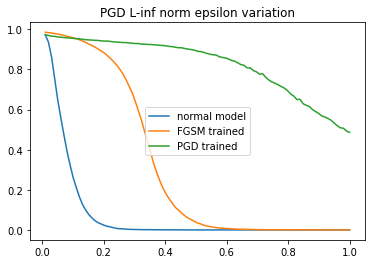

In [ ]:
plt.plot(list(acc_dict.keys()), list(acc_dict.values()))
plt.legend(['normal model', 'FGSM trained', 'PGD trained'])
plt.title('PGD L-inf norm epsilon variation')

### CW Parameter Variation test


In [ ]:
if device == 'cpu':
    model1 = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/normal_trained_model.pkl', 'rb')).load()
    # model2 = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/fgsm_trained_model.pkl', 'rb')).load()
    model3 = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/pgd_trained_model.pkl', 'rb')).load()
else:
    model1 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/normal_trained_model.pkl', 'rb'))
    # model2 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/fgsm_trained_model.pkl', 'rb'))
    model3 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/pgd_trained_model.pkl', 'rb'))

model_list = [model1, model3]

adv_val = True
# pgd_epsilon_list = list(np.linspace(0, 6, num=100, endpoint=True))
cw_c_list = range(0, 50, 1)
attack = 'cw'
acc_dict = {}
logs = {}
LR = 0.5
KAPPA = 0
STEPS = 30

for c in cw_c_list:
    
    model_acc_list = []
    for model in model_list:

        C = c

        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()
        print('CW attack with c', C, 'result:')
        model, val_acc = only_val_loop(model, criterion, valid_loader, 1, device, adv_val, attack)
        model_acc_list.append(val_acc[0].cpu())

    acc_dict[c] = tuple(model_acc_list)

CW attack with c 0 result:
14:23:56 --- Epoch: 0	Valid loss: 0.0437	Valid acc: 98.65	ADV Valid acc: 98.51	ADV Valid loss: 4.45
CW attack with c 0 result:
14:24:03 --- Epoch: 0	Valid loss: 0.0496	Valid acc: 98.42	ADV Valid acc: 98.19	ADV Valid loss: 5.05
CW attack with c 1 result:
14:24:22 --- Epoch: 0	Valid loss: 0.0437	Valid acc: 98.65	ADV Valid acc: 24.29	ADV Valid loss: 76.39
CW attack with c 1 result:
14:24:28 --- Epoch: 0	Valid loss: 0.0496	Valid acc: 98.42	ADV Valid acc: 86.71	ADV Valid loss: 20.05
CW attack with c 2 result:
14:24:44 --- Epoch: 0	Valid loss: 0.0437	Valid acc: 98.65	ADV Valid acc: 7.25	ADV Valid loss: 102.39
CW attack with c 2 result:
14:25:00 --- Epoch: 0	Valid loss: 0.0496	Valid acc: 98.42	ADV Valid acc: 69.81	ADV Valid loss: 29.02
CW attack with c 3 result:
14:25:16 --- Epoch: 0	Valid loss: 0.0437	Valid acc: 98.65	ADV Valid acc: 3.02	ADV Valid loss: 115.72
CW attack with c 3 result:
14:25:32 --- Epoch: 0	Valid loss: 0.0496	Valid acc: 98.42	ADV Valid acc: 61.60	

Text(0.5, 1.0, 'CW "c" variation')

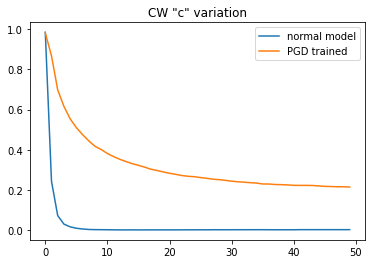

In [ ]:
plt.plot(list(acc_dict.keys()), list(acc_dict.values()))
plt.legend(['normal model', 'PGD trained'])
plt.title('CW "c" variation')

### DeepFool Parameter Variation Test


In [ ]:
if device == 'cpu':
    model1 = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/normal_trained_model.pkl', 'rb')).load()
    # model2 = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/fgsm_trained_model.pkl', 'rb')).load()
    model3 = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/pgd_trained_model.pkl', 'rb')).load()
else:
    model1 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/normal_trained_model.pkl', 'rb'))
    # model2 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/fgsm_trained_model.pkl', 'rb'))
    model3 = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/pgd_trained_model.pkl', 'rb'))

model_list = [model1, model3]

adv_val = True
# pgd_epsilon_list = list(np.linspace(0, 6, num=100, endpoint=True))
deepfool_steps_list = range(8, 12, 1)
attack = 'deepfool'
acc_dict = {}
logs = {}
OVERSHOOT = 0.2

for df_steps in deepfool_steps_list:
    
    model_acc_list = []
    for model in model_list:

        DF_STEPS = df_steps

        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()
        print('DeepFool attack with steps', DF_STEPS, 'result:')
        model, val_acc = only_val_loop(model, criterion, valid_loader, 1, device, adv_val, attack)
        model_acc_list.append(val_acc[0].cpu())

    acc_dict[df_steps] = tuple(model_acc_list)

DeepFool attack with steps 8 result:
05:18:31 --- Epoch: 0	ADV Valid acc: 65.44	ADV Valid loss: 93.16
DeepFool attack with steps 8 result:
05:36:11 --- Epoch: 0	ADV Valid acc: 41.77	ADV Valid loss: 72.13
DeepFool attack with steps 9 result:
05:55:25 --- Epoch: 0	ADV Valid acc: 62.29	ADV Valid loss: 93.31
DeepFool attack with steps 9 result:
06:14:08 --- Epoch: 0	ADV Valid acc: 31.55	ADV Valid loss: 80.27
DeepFool attack with steps 10 result:
06:34:55 --- Epoch: 0	ADV Valid acc: 59.11	ADV Valid loss: 93.38
DeepFool attack with steps 10 result:
06:54:34 --- Epoch: 0	ADV Valid acc: 21.98	ADV Valid loss: 87.34
DeepFool attack with steps 11 result:


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'DeepFool steps variation')

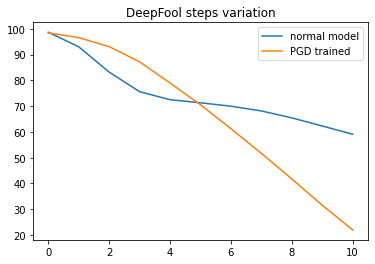

In [ ]:
keys = range(11)
values = [(98.65, 98.42), (93.01, 96.57), (83.2, 93.08), (75.59, 87.19), (72.49, 78.95), (71.29, 70.54), (69.97, 61.25), (68.13, 51.7), (65.44, 41.77), (62.29, 31.55), (59.11, 21.98)]
# plt.plot(list(acc_dict.keys()), list(acc_dict.values()))
plt.plot(keys, values)
plt.legend(['normal model', 'PGD trained'])
plt.title('DeepFool steps variation')

### Model Save/Load

In [ ]:
pickle.dump(model, open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/pgd_trained_model.pkl', 'wb'))

In [ ]:
model = CPU_Unpickler(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/normal_trained_model.pkl', 'rb')).load()

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/Adversarial Machine Learning/Trained Model/pgd_trained_model.pkl', 'rb'))

### Test

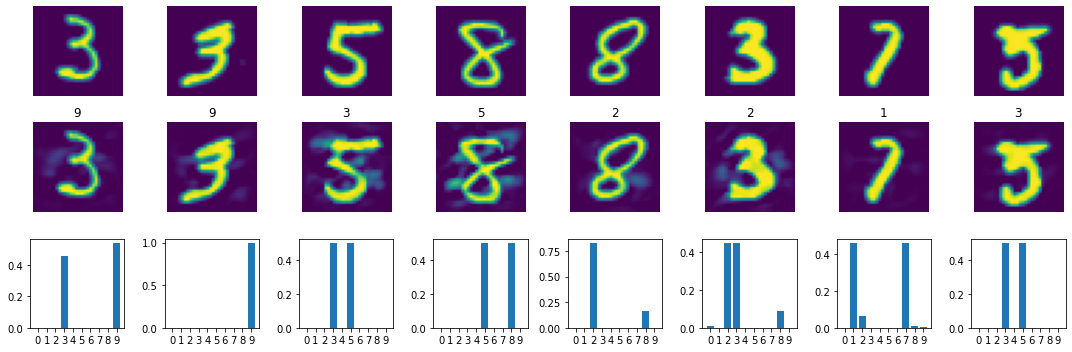

In [ ]:
## PGD

loss_fn  = torch.nn.CrossEntropyLoss()
num_steps = 10
step_size = 0.3
eps = 3     # 0.0, 6.1, 1./3
step_norm = 2
eps_norm = 2    # 'inf'/2

## FGSM

fgsm_epsilon = 0.2

fig=plt.figure(figsize=(15,5))
# labels = ['normal/noise', 'adversarial']

def inference(model, dataset_sample, i, n_samples):
    
    sample = dataset_sample[0]
    y = torch.tensor(dataset_sample[1], device=device).unsqueeze(0)
    x = sample.unsqueeze(0)
    x = x.to(device)

    sub = fig.add_subplot(3, n_samples, i+1)
    plt.axis('off')
    plt.imshow(x[0][0].detach().cpu().numpy())

    # x_adv = projected_gradient_descent(model, x.to(device), y.to(device), loss_fn, num_steps, step_size, step_norm, eps, eps_norm)
    # x_adv = FGSM(model, x.to(device), y, fgsm_epsilon)
    
    # atk = CarliniL0(model, num_labels = 10, max_iterations=10, initial_const=1, largest_const=15)
    # atk = torchattacks.CW(model, c=5, kappa=0.3, steps=10, lr=0.5)
    atk = torchattacks.DeepFool(model, steps=50, overshoot=0.2)

    # atk = JSMA(model, num_classes = 10)

    x_adv = atk(x, y)
    # x_adv = atk.attack(x, y)
    
    y_hat = model(x_adv)
    y_prob = F.softmax(y_hat, dim=1)
    _, predicted_labels = torch.max(y_prob, 1)

    sub = fig.add_subplot(3, n_samples, n_samples+i+1)
    # plt.subplot(2, 5, i+1)
    plt.axis('off')
    sub.set_title(predicted_labels.item())
    plt.imshow(x_adv[0][0].detach().cpu().numpy())
    plt.tight_layout()

    sub = fig.add_subplot(3, n_samples, 2*n_samples+i+1)
    plt.xticks(range(10))
    plt.bar(range(10), y_prob[0].tolist())

    # print(torch.sum(x != x_adv).item())

n_samples = 8
indices = random.sample(range(0, len(valid_dataset)), n_samples)
for i, index in enumerate(indices):
    inference(model, valid_dataset[index], i, n_samples)

P( 5 ) = 0.9995871186256409
P( 3 ) = 0.5036439895629883

P( 5 ) = 0.9999067783355713
P( 8 ) = 0.5336227416992188

P( 3 ) = 0.9999927282333374
P( 8 ) = 0.5697371363639832



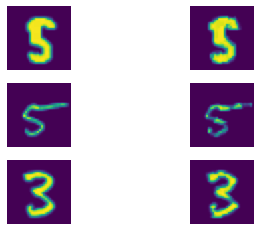

In [ ]:
## PGD

loss_fn  = torch.nn.CrossEntropyLoss()
num_steps = 10
step_size = 0.03
eps = 0.3     # 0.0, 6.1, 1./3
step_norm = 'inf'
eps_norm = 'inf'

## FGSM

fgsm_epsilon = 0.2

index = 6
i = 0
for x, y in train_loader:
    plt.subplot(3, 2, i+1)
    plt.axis('off')
    plt.imshow(x[0][0])
    i = i+1

    logits = model(x.to(device))
    probs = F.softmax(logits, dim=1)

    ind = torch.argmax(probs[0], dim=0)
    print('P(', ind.item(), ') =', probs[0][ind].item())

    # x = train_dataset.data[index].unsqueeze(0).unsqueeze(0)
    # print(x)
    # y = train_dataset.train_labels[index]
    
    # x_adv = projected_gradient_descent(model, x.to(device), y.to(device), LOSS_FN, NUM_STEPS, STEP_SIZE, STEP_NORM, EPS, EPS_NORM)
    # x_adv = FGSM(model, x.to(device), y.to(device), fgsm_epsilon)
    
    # atk = torchattacks.FGSM(model, eps=fgsm_epsilon)
    # atk = torchattacks.PGD(model, eps=eps, alpha=step_size, steps=num_steps)
    atk = torchattacks.CW(model, c=10, kappa=0, steps=100, lr=0.5)
    # atk = torchattacks.DeepFool(model, steps=50, overshoot=0.2)
    x_adv = atk(x, y)

    x_adv = x_adv.detach()
    plt.subplot(3, 2, i+1)
    plt.axis('off')
    plt.imshow(x_adv[0][0].cpu())

    logits = model(x_adv.to(device))
    probs = F.softmax(logits, dim=1)
    ind = torch.argmax(probs[0], dim=0)
    print('P(', ind.item(), ') =', probs[0][ind].item())

    print('')

    i = i+1
    if i == index:
        break

In [ ]:
adv_val = True
attack = 'cw'

criterion = nn.CrossEntropyLoss()
model, _ = only_val_loop(model, criterion, valid_loader, 1, device, adv_val, attack)

13:46:34 --- Epoch: 0	Valid loss: 0.0496	Valid acc: 98.42	ADV Valid acc: 87.02	ADV Valid loss: 12.47


In [ ]:
adv_val = True
attack = 'deepfool'

criterion = nn.CrossEntropyLoss()
model, _ = only_val_loop(model, criterion, valid_loader, 1, device, adv_val, attack)

14:29:50 --- Epoch: 0	Valid loss: 0.0496	Valid acc: 98.42	ADV Valid acc: 0.01	ADV Valid loss: 99.58


<BarContainer object of 7 artists>

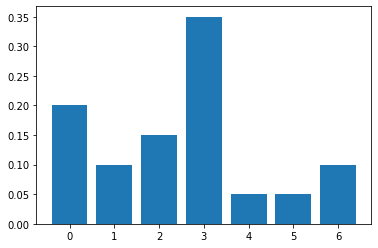

In [ ]:
p = [0.2, 0.1, 0.15, 0.35, 0.05, 0.05, 0.1]
plt.bar(range(7), p)

In [ ]:
t = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.float64)
t.norm(0, dim=0)

tensor(10., dtype=torch.float64)